In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
#warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.features as fs
import matplotlib.pyplot as plt
import pattern.vis as vis
import matplotsoccer as mps
#import atomic.vaep as vaep
import pattern.action as pat
import atomic.atomic_spadl as ato

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
#actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        a["is_home"] = a.team_id == game.home_team_id
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:09, 39.49it/s]


game_id  period_id  action_id  time_seconds     timestamp  team_id  \
0  14562.0        1.0          0           1.0  00:00:01.344     58.0   
1  14562.0        1.0          1           1.5  00:00:02.117     58.0   
2  14562.0        1.0          2           2.0  00:00:02.117     58.0   
3  14562.0        1.0          3           2.0  00:00:02.969     58.0   
4  14562.0        1.0          4           3.0  00:00:04.338     58.0   

   player_id          x          y         dx         dy  type_id  \
0     9923.0  52.058824  34.430380 -10.588235  -0.000000        0   
1     9917.0  41.470588  34.430380  -0.000000  -0.000000       23   
2     9917.0  41.470588  34.430380  -0.000000  -0.000000       21   
3     9917.0  41.470588  34.430380 -15.882353 -14.632911        0   
4     9924.0  25.588235  19.797468  -0.000000  -0.000000       23   

   bodypart_id  is_home type_name  
0            0    False      pass  
1            0    False  receival  
2            0    False   dribble  
3            0    False      pass  
4            0    False  receival

In [365]:
# Make a nice action subset
import pattern.action as pat

a = actions[500000:600000].fillna(0)
#a = actions.fillna(0)
a = pat.simplify(a)
#a["type_name"] = a.type_name.mask(~a.is_home,a.type_name + "_opp")
a["x"] = a.x.mask(a.type_name=="goal",105)
a["y"] = a.y.mask(a.type_name=="goal",34)
a["x"] = a.x.mask(a.type_name=="shot_penalty",94.5)
a["y"] = a.y.mask(a.type_name=="shot_penalty",34)
#a["dx"] = a.dx.mask(a.type_name=="shot",105-a.x)
#a["dy"] = a.dy.mask(a.type_name=="shot",32.5-a.y)

def fix_out_y(y):
    return 68 if 68 - y < y else 0

a["y"] = a.y.mask(a.type_name=="out",a.y.apply(fix_out_y))

import numpy as np
a["x"] = a.x + np.random.normal(0,1,len(a))
a["y"] = a.y + np.random.normal(0,1,len(a))
#a["dx"] = a.dx + (a.dx != 0).apply(int) * np.random.normal(0,1,len(a))
#a["dy"] = a.dy + (a.dy != 0).apply(int) * np.random.normal(0,1,len(a))
a["dx"] = a.dx + np.random.normal(0,1,len(a))
a["dy"] = a.dy + np.random.normal(0,1,len(a))

#a = pd.concat([a,fs.polar(a),fs.movement_polar(a),fs.direction(a)],axis=1)
mirror_a = a.copy()
mirror_a["y"] = 68 - mirror_a["y"]
mirror_a["dy"] = - mirror_a["dy"]
a = pd.concat([a,mirror_a],axis=0)
a = pd.concat([a,fs.polar(a),fs.movement_polar(a),fs.direction(a)],axis=1)
#a = a[~(((a.type_name == "dribble") | (a.type_name == "pass")) & (a.mov_d_a0 < 5))]
a

game_id  period_id  action_id  time_seconds     timestamp  team_id  \
500000  14564.0        1.0       1097        1888.0  00:31:28.903     38.0   
500001  14564.0        1.0       1098        1889.0  00:31:30.182     38.0   
500002  14564.0        1.0       1099        1890.0  00:31:30.182     38.0   
500003  14564.0        1.0       1100        1892.0  00:31:32.773     38.0   
500004  14564.0        1.0       1101        1892.5  00:31:33.854     38.0   
...         ...        ...        ...           ...           ...      ...   
599995  14385.0        2.0       2596        1171.0  00:19:31.746     25.0   
599996  14385.0        2.0       2597        1174.0  00:19:34.463     25.0   
599997  14385.0        2.0       2598        1174.5  00:19:35.468     25.0   
599998  14385.0        2.0       2599        1175.0  00:19:35.468     25.0   
599999  14385.0        2.0       2600        1176.0  00:19:36.704     25.0   

        player_id          x          y        dx  ...  type_id  bodypart_id  \
500000     3043.0  62.086829  35.949591 -8.022263  ...        0            0   
500001     3098.0  55.585828  39.747310 -0.955314  ...       23            0   
500002     3098.0  56.190560  38.652327 -2.790011  ...       21            0   
500003     3098.0  51.799823  40.651369  2.795573  ...        0            0   
500004     3043.0  58.001705  34.712992 -0.752313  ...       23            0   
...           ...        ...        ...       ...  ...      ...          ...   
599995     3329.0  18.923339  57.789321  7.301004  ...       21            0   
599996     3329.0  24.141018  63.693785  7.475623  ...        0            0   
599997     3570.0  31.312624  47.347112 -0.448433  ...       23            0   
599998     3570.0  32.340405  45.555731  1.903935  ...       21            0   
599999     3570.0  34.450263  46.251953  2.689609  ...        0            0   

        is_home  type_name dist_to_goal_a0  angle_to_goal_a0   mov_d_a0  \
500000     True       pass       42.957434          0.045400   8.723939   
500001     True   receival       49.747281          0.115789   1.884236   
500002     True    dribble       49.030660          0.095029   2.869507   
500003     True       pass       53.614360          0.124380   5.688502   
500004     True   receival       47.003703          0.015169   0.888852   
...         ...        ...             ...               ...        ...   
599995    False    dribble       89.303547          0.269643   8.409002   
599996    False       pass       86.138818          0.351941  19.324767   
599997    False   receival       74.886412          0.179189   0.461945   
599998    False    dribble       73.572765          0.157718   2.119296   
599999    False       pass       71.605696          0.171949  18.314085   

        mov_angle_a0     dx_a0     dy_a0  
500000      2.737778 -0.919569  0.392929  
500001     -2.102501 -0.507003 -0.861944  
500002      2.905658 -0.972296  0.233752  
500003     -1.057051  0.491443 -0.870910  
500004      2.579961 -0.846387  0.532568  
...              ...       ...       ...  
599995      0.519159  0.868237  0.496150  
599996     -1.173592  0.386842 -0.922146  
599997     -2.899132 -0.970750 -0.240092  
599998      0.454728  0.898381  0.439218  
599999      1.423403  0.146860  0.989157  

[200000 rows x 21 columns]

In [366]:
import pattern.mixture as mix

model1 = mix.CategoricalModel()
model1.fit(a["type_name"])
w1 = model1.predict_proba(a["type_name"])

In [367]:
# construct weights and n_components
from sklearn.neighbors import LocalOutlierFactor as LOF

cols2 = ["x","y",]

def remove_outliers(weights,df,cols,tol=1e-4):
    for column in weights.columns:
        idx = weights[column] > tol
        c = LOF(contamination="auto").fit_predict(df[idx][cols])
        idx[idx] = c == 1
        w1[column] = w1[column].mask(~idx, 0)
    return weights

#print(w1.sum())
w1 = remove_outliers(w1,a,cols2)
#print(w1.sum())
experiments = {name : range(1,10) for name in w1.columns}
experiments["pass"] = range(10,30)
experiments["dribble"] = range(10,30)
experiments["receival"] = range(10,30)
experiments

{'throw_in': range(1, 10),
 'take_on': range(1, 10),
 'goal': range(1, 10),
 'owngoal': range(1, 10),
 'tackle': range(1, 10),
 'offside': range(1, 10),
 'goalkick': range(1, 10),
 'corner': range(1, 10),
 'foul': range(1, 10),
 'cross': range(1, 10),
 'freekick': range(1, 10),
 'yellow_card': range(1, 10),
 'pass': range(10, 30),
 'out': range(1, 10),
 'clearance': range(1, 10),
 'shot': range(1, 10),
 'red_card': range(1, 10),
 'dribble': range(10, 30),
 'shot_penalty': range(1, 10),
 'bad_touch': range(1, 10),
 'keeper_catch': range(1, 10),
 'interception': range(1, 10),
 'receival': range(10, 30)}

In [ ]:
import mixture as mix
mps.field(show=False)
idx = w1["shot_penalty"] == 1
plt.scatter(a[idx].x,a[idx].y)
plt.show()
sum(idx)
mix.MixtureModel(6).fit(a[idx][cols2]).params()

# cluster.KMeans(n_clusters=2, n_init=10).fit(
#     a[idx][cols2],
# ).__dict__


In [271]:
import mixture as mix
# non-dask
a_fut = a
w_fut = w1
models = []
for name in experiments:
    #if name not in ["dribble","pass","receival"]:
    if name in ["shot_penalty"]:
        for i in experiments[name]:
            print(f"{name}_{i}")
            model = mix.learn_mixture(a_fut,cols2,w_fut,name,i)
            if model:
                models.append(model)

shot_penalty_1
shot_penalty_2
shot_penalty_3
shot_penalty_4
shot_penalty_5
shot_penalty_6
shot_penalty_7
shot_penalty_8
shot_penalty_9


In [368]:
from dask.distributed import Client
import mixture as mix

# def learn_mixture(a,c,w,n,i):
#     import mixture

with Client("glados:8786") as client:
    client.run(lambda: print("hello world"))
    client.upload_file('mixture.py')
    a_fut = client.scatter(a, broadcast=True)
    w_fut = client.scatter(w1, broadcast=True)
    futures = []
    for name in experiments:
        #if name not in ["dribble","pass","receival"]:
        #if name in ["shot_penalty"]:
        for i in experiments[name]:
            future = client.submit(mix.learn_mixture,
                                   a_fut,
                                   cols2,
                                   w_fut,
                                   name,
                                   i,
                                   key=f"{name}_{i}")
            futures.append(future)
    models = client.gather(futures)

In [369]:
# for model in models:
#     model.weights = w[model.name].values
#     model.df = a
#     model.columns = cols
can_i = list(m for m in models if ("loglikelihood" in m.__dict__) and (not np.isinf(m.loglikelihood)))
len(models),len(can_i)

(240, 234)

In [426]:
import mixture
for can in can_i:
    for m in can.submodels:
        m._n_parameters = 5
    can.submodels[0]._n_parameters = 0
    #print(can.name,can._n_parameters())
        #print(m._n_parameters)

In [427]:
models_all = mix.ilp_select_models_bic(can_i,verbose=True)
models_all_ = {m.name : m.k for m in models_all}
models_solo = mix.select_models_solo_bic(can_i)
models_solo_ = {m.name : m.k for m in models_solo}
list((m.name,models_all_[m.name], models_solo_[m.name]) for m in models_all)

Iter	Lower Bound	Upper Bound	Gap

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.452e+06  +1.736e+06  +2e+06  7e-03  1e-10  1e+00  4e+03    ---    ---    1  1  - |  -  - 
 1  +3.443e+06  +3.231e+06  +2e+05  6e-04  1e-11  2e+01  5e+02  0.8785  5e-03   0  1  1 |  0  0
 2  +3.442e+06  +3.377e+06  +7e+04  2e-04  4e-12  1e+02  1e+02  0.9890  3e-01   0  2  1 |  0  0
 3  +3.440e+06  +3.431e+06  +1e+04  3e-05  5e-13  2e+01  2e+01  0.8584  5e-03   0  1  1 |  0  0
 4  +3.438e+06  +3.435e+06  +3e+03  9e-06  2e-13  6e+00  6e+00  0.9310  2e-01   0  2  1 |  0  0
 5  +3.437e+06  +3.437e+06  +5e+02  2e-06  3e-14  1e+00  1e+00  0.9648  2e-01   0  1  1 |  0  0
 6  +3.437e+06  +3.437e+06  +5e+01  3e-07  9e-15  1e-01  1e-01  0.9661  7e-02   0  1  1 |  0  0
 7  +3.437e+06  +3.437e+06  +6e-01  1e-08  6e-16  1e-03  1e-03  0.9890  1e-04   0  1  1 |  0  0
 8  +3.437e+0

[('throw_in', 8, 8),
 ('take_on', 7, 7),
 ('goal', 1, 1),
 ('owngoal', 1, 8),
 ('tackle', 7, 7),
 ('offside', 1, 3),
 ('goalkick', 2, 2),
 ('corner', 2, 2),
 ('foul', 3, 3),
 ('cross', 4, 8),
 ('freekick', 3, 8),
 ('yellow_card', 1, 4),
 ('pass', 28, 28),
 ('out', 6, 8),
 ('clearance', 5, 5),
 ('shot', 3, 3),
 ('red_card', 2, 4),
 ('dribble', 27, 27),
 ('shot_penalty', 1, 9),
 ('bad_touch', 3, 8),
 ('keeper_catch', 2, 2),
 ('interception', 8, 8),
 ('receival', 26, 28)]

In [428]:
def probabilities(models,df,columns,weights_df):
    weights = []
    for model in models:
        probs = model.predict_proba(df[columns].values,weights_df[model.name].values)
        nextlevel_columns = list(f"{model.name}_{i}" for i in range(model.k))
        weights.append(pd.DataFrame(probs,columns=nextlevel_columns))
    return pd.concat(weights,axis=1)

models_i = models_all
w_i = probabilities(models_i,a,cols2,w1)
w_i

throw_in_0  throw_in_1  throw_in_2  throw_in_3  throw_in_4  \
0              0.0         0.0         0.0         0.0         0.0   
1              0.0         0.0         0.0         0.0         0.0   
2              0.0         0.0         0.0         0.0         0.0   
3              0.0         0.0         0.0         0.0         0.0   
4              0.0         0.0         0.0         0.0         0.0   
...            ...         ...         ...         ...         ...   
199995         0.0         0.0         0.0         0.0         0.0   
199996         0.0         0.0         0.0         0.0         0.0   
199997         0.0         0.0         0.0         0.0         0.0   
199998         0.0         0.0         0.0         0.0         0.0   
199999         0.0         0.0         0.0         0.0         0.0   

        throw_in_5  throw_in_6  throw_in_7  take_on_0  take_on_1  ...  \
0              0.0         0.0         0.0        0.0        0.0  ...   
1              0.0         0.0         0.0        0.0        0.0  ...   
2              0.0         0.0         0.0        0.0        0.0  ...   
3              0.0         0.0         0.0        0.0        0.0  ...   
4              0.0         0.0         0.0        0.0        0.0  ...   
...            ...         ...         ...        ...        ...  ...   
199995         0.0         0.0         0.0        0.0        0.0  ...   
199996         0.0         0.0         0.0        0.0        0.0  ...   
199997         0.0         0.0         0.0        0.0        0.0  ...   
199998         0.0         0.0         0.0        0.0        0.0  ...   
199999         0.0         0.0         0.0        0.0        0.0  ...   

         receival_16   receival_17  receival_18   receival_19   receival_20  \
0       0.000000e+00  0.000000e+00     0.000000  0.000000e+00  0.000000e+00   
1       4.039314e-28  3.311413e-13     0.000629  1.010333e-06  8.897593e-08   
2       0.000000e+00  0.000000e+00     0.000000  0.000000e+00  0.000000e+00   
3       0.000000e+00  0.000000e+00     0.000000  0.000000e+00  0.000000e+00   
4       8.847162e-31  4.210380e-13     0.000258  2.899354e-09  1.822916e-05   
...              ...           ...          ...           ...           ...   
199995  0.000000e+00  0.000000e+00     0.000000  0.000000e+00  0.000000e+00   
199996  0.000000e+00  0.000000e+00     0.000000  0.000000e+00  0.000000e+00   
199997  4.970047e-08  3.218775e-08     0.029678  1.908836e-02  7.965337e-21   
199998  0.000000e+00  0.000000e+00     0.000000  0.000000e+00  0.000000e+00   
199999  0.000000e+00  0.000000e+00     0.000000  0.000000e+00  0.000000e+00   

         receival_21   receival_22   receival_23   receival_24   receival_25  
0       0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
1       1.709698e-32  3.292610e-12  1.564533e-03  1.727174e-04  2.719639e-02  
2       0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
3       0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
4       3.703397e-45  8.637524e-10  2.693997e-04  2.394691e-03  8.883962e-02  
...              ...           ...           ...           ...           ...  
199995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
199996  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
199997  9.517211e-25  2.966147e-17  5.186998e-09  1.167937e-07  6.460257e-09  
199998  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
199999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  

[200000 rows x 151 columns]

throw_in 8
[71.22435614 68.01510405]
[45.95669038 -0.09351547]
[92.58436998 -0.13171082]
[23.0817275  68.01003382]
[92.65846492 68.12890711]
[ 7.10765987e+01 -1.32464665e-02]
[ 2.28485163e+01 -1.45731784e-03]
[46.20328737 68.08819147]


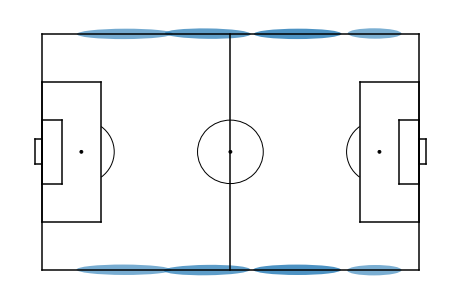

take_on 7
[89.24616671 52.02452819]
[36.12409997 17.72134093]
[36.11133059 50.19650743]
[89.35791656 16.13040551]
[66.81311908 33.8968055 ]
[63.67686019 63.24784025]
[64.09333851  4.78343875]


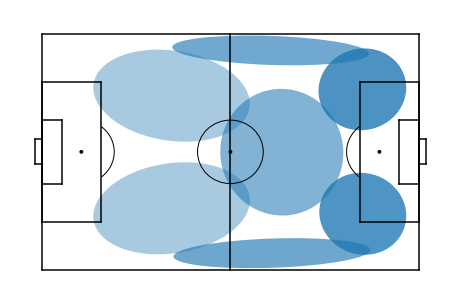

goal 1
[105.0311906  34.       ]


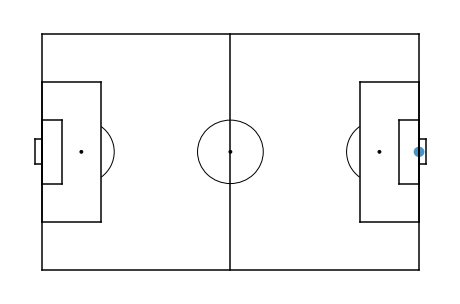

owngoal 1
[ 7.30673166 34.        ]


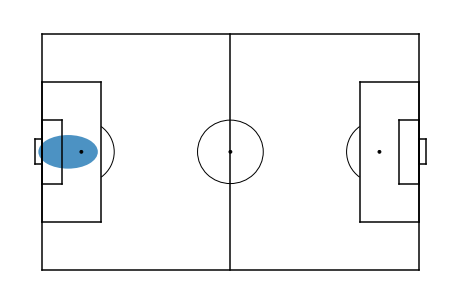

tackle 7
[66.99458551 51.27115481]
[34.05000796 34.05222488]
[43.47222835  4.95178856]
[12.2256861  13.19942662]
[12.18174052 54.73835505]
[67.01365295 16.72982552]
[43.33069814 63.06628515]


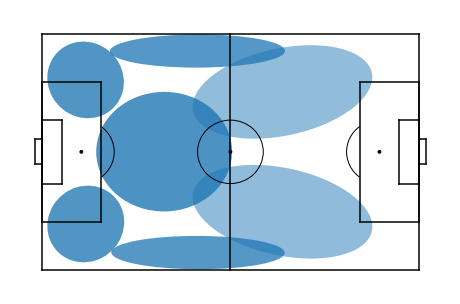

offside 1
[84.36782294 34.        ]


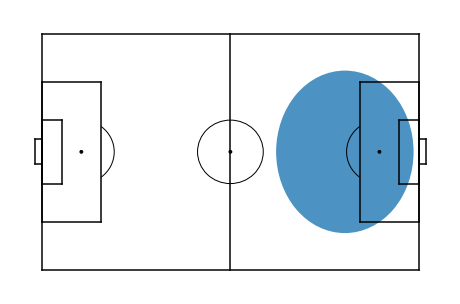

goalkick 2
[ 5.07271016 35.47678942]
[ 5.07271016 32.52321058]


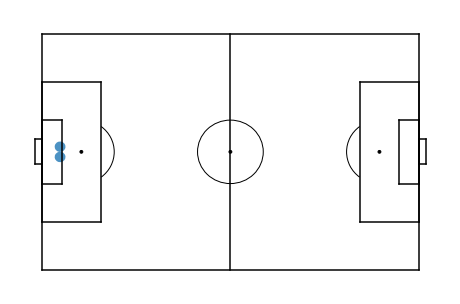

corner 2
[105.06276199  68.02300744]
[ 1.05062762e+02 -2.30074431e-02]


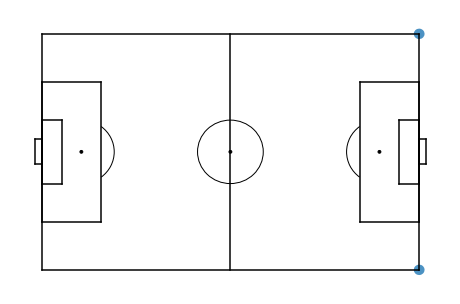

foul 3
[47.45845271 53.58193434]
[47.45845271 14.41806566]
[80.52265824 34.        ]


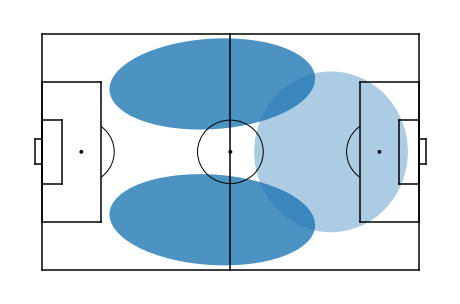

cross 4
[87.13167784 60.46831245]
[87.13167784  7.53168755]
[99.49561781 13.97573387]
[99.49561781 54.02426613]


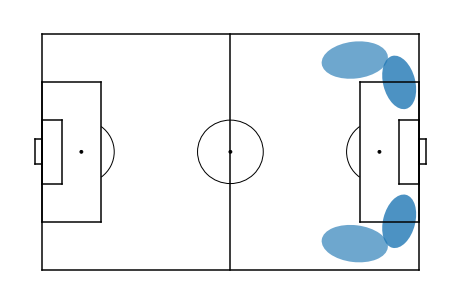

freekick 3
[55.01393497 14.70848817]
[15.25729666 33.9701005 ]
[54.98745947 53.34128139]


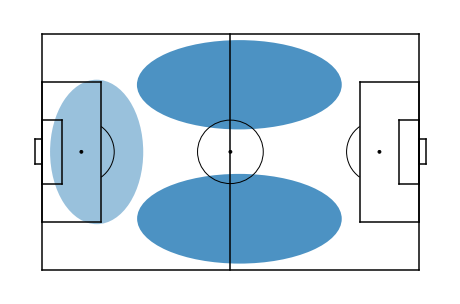

yellow_card 1
[44.16046685 34.        ]


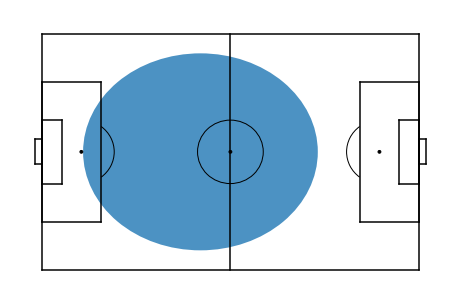

pass 28
[59.49392257  6.20846001]
[44.56136635 61.49270891]
[45.98369634 20.9020643 ]
[ 9.45170181 33.98842103]
[83.84410546 62.94868408]
[70.52576508 17.4408049 ]
[35.65707061 33.06186605]
[79.88564264 48.69273538]
[10.5181853 11.8857892]
[51.76705033 34.02468483]
[22.52561379 22.95862683]
[92.49584344  6.97466735]
[24.62861377 45.062749  ]
[58.48411224 20.41388223]
[29.34550385  5.65468527]
[64.09759519 47.59804367]
[29.55658176 61.25377869]
[70.19731101 62.16344782]
[96.2278519  54.75398094]
[11.38895858 55.91252136]
[74.14243266  5.14231459]
[44.8458012   6.95756692]
[34.89932582 18.10063161]
[51.35086697 49.44234126]
[71.09466209 33.10639997]
[84.07508707 19.84677958]
[58.47257977 61.60384068]
[40.00055644 46.80080502]


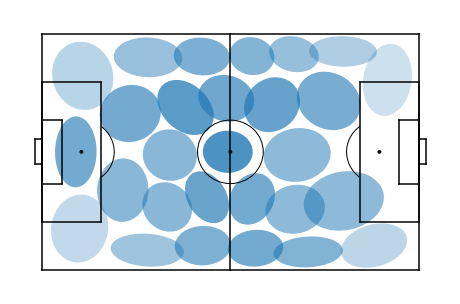

out 6
[ 1.04682504e+02 -1.65417660e-02]
[69.80166098 68.0471902 ]
[24.11662561  0.03712852]
[24.11662561 67.96287148]
[104.68250382  68.01654177]
[ 6.98016610e+01 -4.71901987e-02]


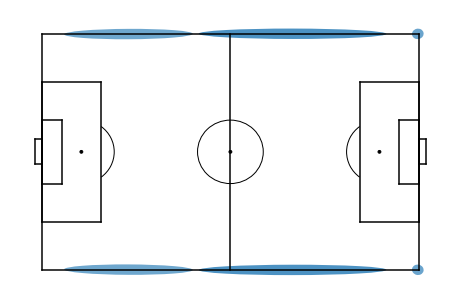

clearance 5
[35.70598982 50.68512927]
[14.23683079 46.92902325]
[35.90773783 17.34644774]
[14.34641172 20.80680118]
[ 7.58511094 33.9849313 ]


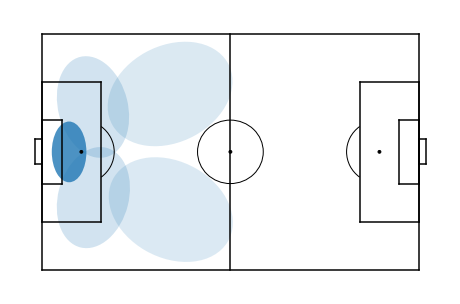

shot 3
[87.38102388 42.18633877]
[87.25147357 25.96439436]
[97.9045763  33.98125359]


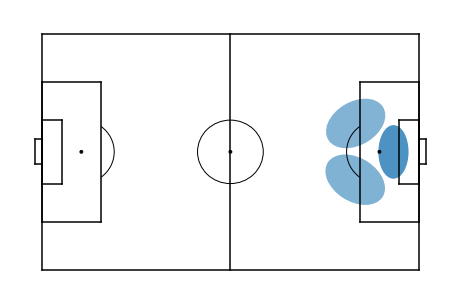

red_card 2
[43.80623566 34.        ]
[77.94226482 34.        ]


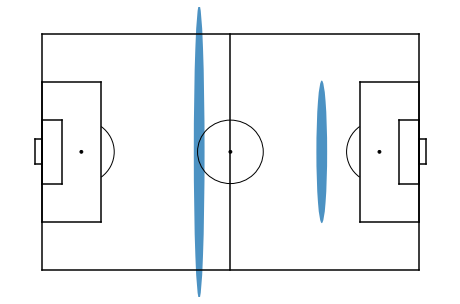

dribble 27
[60.11464296 61.52900145]
[35.80383213 33.62161333]
[77.18268317 17.43616941]
[ 6.64501475 34.0903298 ]
[45.1683101   6.44825535]
[29.66388455 61.44565844]
[60.63683526 47.2413137 ]
[76.5618204  50.82588898]
[12.65959682 13.14419573]
[25.28031032 22.85229587]
[46.44313743 46.6709814 ]
[61.10000807 20.09566045]
[22.50181614 44.18103251]
[43.96313883 20.2176534 ]
[92.74185879 22.43964501]
[30.50985962  8.26052277]
[90.59488457  6.88891845]
[91.10901584 60.72613782]
[72.97628657 33.94324609]
[73.9790131   4.22699575]
[11.71473436 55.03938216]
[51.99238982 33.50013696]
[59.47332502  6.15504141]
[34.90687629 48.61946563]
[92.33789965 45.30074138]
[45.10786454 61.00790873]
[74.8414889  64.08032389]


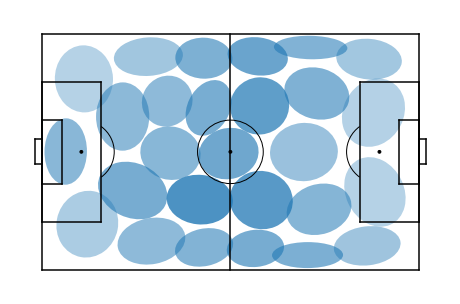

shot_penalty 1
[95.2487954 34.       ]


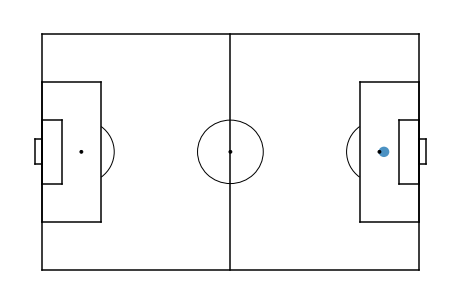

bad_touch 3
[56.72940271 55.95704572]
[87.43445974 33.90758417]
[56.59524915 12.16120611]


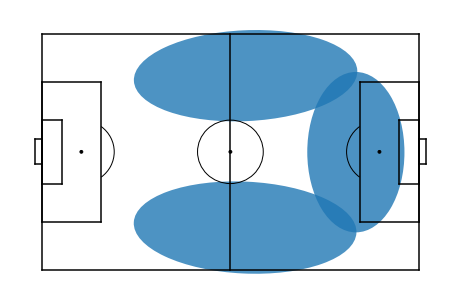

keeper_catch 2
[ 2.03598931 34.        ]
[12.05760356 34.        ]


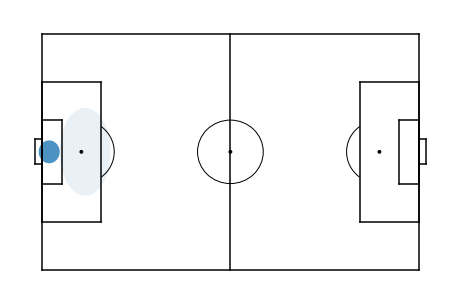

interception 8
[22.44821422 17.26329976]
[49.36961135 57.86690209]
[43.72400646 33.98885177]
[22.44896454 50.73534243]
[ 7.80929598 33.99986408]
[77.71938917 47.25701265]
[77.72007401 20.74455298]
[49.37214441 10.12599276]


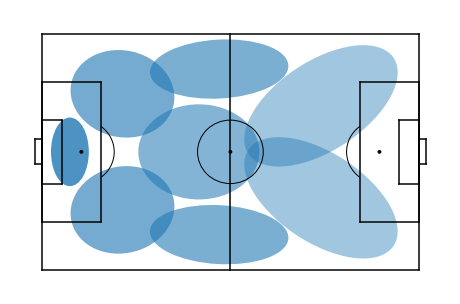

receival 26
[25.68599577 22.90741308]
[92.77301046 45.74625528]
[46.04864723 60.95807576]
[60.91744881 19.5639189 ]
[91.23527151 60.7689219 ]
[25.90033166 44.78051292]
[58.8183071 47.5043488]
[90.83158763  6.76873149]
[51.1248539  33.72050392]
[45.83120315  6.74417123]
[13.89423116 54.91900045]
[74.3485262   4.31988375]
[95.54646445 23.87624858]
[43.25615303 46.84668001]
[60.45733361 62.11660031]
[59.57396706  5.46743428]
[ 8.06124034 34.00334552]
[13.76904577 12.95470303]
[36.21460374 33.4009089 ]
[31.69792932 60.13473181]
[77.92953443 17.896141  ]
[75.25739638 64.34185443]
[31.56243098  7.94147826]
[74.38932671 51.28473118]
[43.71675569 20.49923289]
[72.91676271 34.46902546]


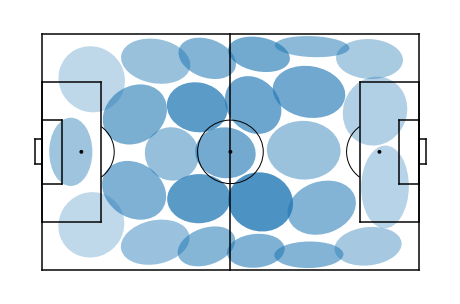

In [429]:
import warnings
warnings.filterwarnings("ignore")

colors = ["#377eb8",
    "#e41a1c",
    "#4daf4a",
    "#984ea3",
    "#ff7f00",
    "#ffff33",
    "#a65628",
    "#f781bf",
    "#999999",
    ]

def scattercolors(actions,weights,samplefn="max"):
    pos_weights_idx = weights.values.sum(axis=1) > 1e-1
    a = actions[pos_weights_idx]
    weights = weights[pos_weights_idx]

    if samplefn == "max":
        labels = np.argmax(weights.values,axis=1)
    else:
        labels = np.apply_along_axis(sample,axis=1, arr=weights.values)

    pcolors = [colors[l % len(colors)] for l in labels]
    return a,pcolors


for model in models_i:
    ax = mps.field(show=False,figsize=8)
    print(model.name,model.n_components)
    #strengths_i = m_i.weights_ / np.max(m_i.weights_) * 0.8
    #for c in w_i.columns:
        #if model.name  + "_" in c:
    norm_strengths = model.priors / np.max(model.priors) * 0.8
    for strength,gauss in zip(norm_strengths,model.submodels):
        print(gauss.mean)
        vis.add_ellips(ax,gauss.mean,gauss.cov,alpha=strength)
            
            #dx = np.average(a["dx"].values,weights=w1[col])
            #dy = np.average(a["x"].values,weights=w1[col])
            
#     for i,(mean,covar,strength_i) in enumerate(zip(m_i.means_, m_i.covariances_,strengths_i)):
#         #print(mean,covar)
#         vis.add_ellips(ax,mean[:2],covar[:2,:2],alpha=strength_i)
#         #vis.add_ellips(ax,mean[:2],[[covar[0],0],[0,covar[1]]],alpha=strength_i)
#         x,y = np.average(m_i.df["dx"].values,weights=we)
#         we = w_i[f"{m_i.name}_{i}"].values
        
#         dx = np.average(m_i.df["dx"].values,weights=we)
#         dy = np.average(m_i.df["dy"].values,weights=we)
#         d = 1
#         strength_ii=1
#         vis.add_arrow(ax,x,y,d*dx,d*dy,
#                                   alpha=strength_ii,
#                                   linewidth=2*strength_ii,
#                                   arrowsize=2.5*strength_ii,
#                                   #linewidth=2,
#                                   threshold=1)
#     plt.title(f"Types of {m_i.name}")
#     plt.show()
    
#     columns = list(f"{m_i.name}_{i}" for i in range(m_i.n_components))
#     acol,c = scattercolors(a,w_i[columns])
    
#     axs = vis.axesxypolar()
#     axs[0].scatter(acol.x,acol.y,c=c)
#     axs[1].scatter(acol.mov_angle_a0,acol.mov_d_a0,c=c)
#     #axs[1].scatter(dfc.x + dfc.dx,dfc.y + dfc.dy,c=dfc.membership,cmap="Blues")
#     #axs[1].scatter(dfc.mov_angle_a0,dfc.mov_d_a0,c=dfc.membership,cmap="Blues")
    plt.show()

In [ ]:
set(np.random.randint(-1,2,len(w)))

In [ ]:
for column in w_i.columns:
    if "pass" in column:
        probs = w_i[column]
        pos_prob_idx = probs > 1e-10
        print(column,sum(pos_prob_idx),sum(probs))
        dfc = a.reset_index()[pos_prob_idx].copy()
        dfc["membership"] = probs[pos_prob_idx]
        dfc = dfc.sort_values("membership",ascending=True)

        axs = vis.axesxypolar()
        sc = axs[0].scatter(dfc.x,dfc.y,c=dfc.membership,cmap="Blues")
        plt.colorbar(sc)
        #axs[1].scatter(dfc.x + dfc.dx,dfc.y + dfc.dy,c=dfc.membership,cmap="Blues")
        axs[1].scatter(dfc.mov_angle_a0,dfc.mov_d_a0,c=dfc.membership,cmap="Blues")
        plt.show()
        plt.hist(dfc.mov_angle_a0,weights=dfc.membership)
        plt.show()

In [430]:
w_i = probabilities(models_i,a,cols2,w1)

cols_ii = [#"x","y",
        #"dx","dy"
        #"dist_to_goal_a0",
        #"angle_to_goal_a0",
        #"mov_d_a0",
        "mov_angle_a0"
        #"dx_a0",
        #"dy_a0"
       ]

# print(w_i.sum())
# for w_i_col in w_i.columns:
#     new_w = w_i[w_i_col] * a.mov_d_a0.values
#     if new_w.sum() > 1e-5:
#         w_i[w_i_col] = new_w
# print(w_i.sum())
experiments = {name : range(1,11) for name in w_i.columns}# if "throw_in" in name}

In [401]:
experiments

{'throw_in_0': range(1, 11),
 'throw_in_1': range(1, 11),
 'take_on_0': range(1, 11),
 'goal_0': range(1, 11),
 'owngoal_0': range(1, 11),
 'tackle_0': range(1, 11),
 'offside_0': range(1, 11),
 'goalkick_0': range(1, 11),
 'corner_0': range(1, 11),
 'corner_1': range(1, 11),
 'foul_0': range(1, 11),
 'cross_0': range(1, 11),
 'cross_1': range(1, 11),
 'freekick_0': range(1, 11),
 'yellow_card_0': range(1, 11),
 'pass_0': range(1, 11),
 'pass_1': range(1, 11),
 'pass_2': range(1, 11),
 'pass_3': range(1, 11),
 'pass_4': range(1, 11),
 'pass_5': range(1, 11),
 'pass_6': range(1, 11),
 'pass_7': range(1, 11),
 'pass_8': range(1, 11),
 'pass_9': range(1, 11),
 'out_0': range(1, 11),
 'out_1': range(1, 11),
 'clearance_0': range(1, 11),
 'clearance_1': range(1, 11),
 'shot_0': range(1, 11),
 'red_card_0': range(1, 11),
 'dribble_0': range(1, 11),
 'dribble_1': range(1, 11),
 'dribble_2': range(1, 11),
 'dribble_3': range(1, 11),
 'dribble_4': range(1, 11),
 'dribble_5': range(1, 11),
 'dri

In [229]:
import mixture as mix
# non-dask
models_ii = []
for name in experiments:
    for i in experiments[name]:
        print(f"{name}_{i}")
        model = mix.learn_mixture(a,cols_ii,w_i,name,i,mix.VonMises)
        if model:
            print(model._n_parameters())
            models_ii.append(model)

throw_in_0_1
3
throw_in_0_2
6
throw_in_0_3
9
throw_in_0_4
12
throw_in_0_5
15
throw_in_0_6
18
throw_in_0_7
21
throw_in_0_8
24
throw_in_0_9
27
throw_in_0_10
30
throw_in_1_1
3
throw_in_1_2
6
throw_in_1_3
9
throw_in_1_4
12
throw_in_1_5
15
throw_in_1_6
18
throw_in_1_7
21
throw_in_1_8
24
throw_in_1_9
27
throw_in_1_10
30
throw_in_2_1
3
throw_in_2_2
6
throw_in_2_3
9
throw_in_2_4
12
throw_in_2_5
15
throw_in_2_6
18
throw_in_2_7
21
throw_in_2_8
24
throw_in_2_9
27
throw_in_2_10
30
throw_in_3_1
3
throw_in_3_2
6
throw_in_3_3
9
throw_in_3_4
12
throw_in_3_5
15
throw_in_3_6
18
throw_in_3_7
21
throw_in_3_8
24
throw_in_3_9
27
throw_in_3_10
30


In [431]:
with Client("glados:8786") as client:
    client.run(lambda: print("hello world again"))
    client.upload_file('mixture.py')
    a_fut = client.scatter(a, broadcast=True)
    w_i_fut = client.scatter(w_i, broadcast=True)
    futures = []
    for name in experiments:
        for i in experiments[name]:
            future = client.submit(mix.learn_mixture,
                                   a_fut,
                                   cols_ii,
                                   w_i_fut,
                                   name,
                                   i,
                                   mix.VonMises,
                                   key=f"{name}_{i}")
            futures.append(future)
    can_ii = client.gather(futures)
can_ii = list(m for m in can_ii if not np.isinf(m.loglikelihood))

OSError: Timed out trying to connect to 'tcp://134.58.41.56:41911' after 10 s: Timed out trying to connect to 'tcp://134.58.41.56:41911' after 10 s: in <distributed.comm.tcp.TCPConnector object at 0x7f368fc586a0>: ConnectionRefusedError: [Errno 111] Connection refused

In [403]:

len(models_ii),len(can_ii)

(570, 520)

In [289]:
for m in can_ii:
    print(m.name,m.weight_total,w_i[m.name].sum())

throw_in_0 1252.0 1252.0
throw_in_0 1252.0 1252.0
throw_in_0 1252.0 1252.0
throw_in_0 1252.0 1252.0
throw_in_0 1252.0 1252.0
throw_in_0 1252.0 1252.0
throw_in_0 1252.0 1252.0
throw_in_0 1252.0 1252.0
throw_in_0 1252.0 1252.0
throw_in_0 1252.0 1252.0
throw_in_1 1238.0 1238.0
throw_in_1 1238.0 1238.0
throw_in_1 1238.0 1238.0
throw_in_1 1238.0 1238.0
throw_in_1 1238.0 1238.0
throw_in_1 1238.0 1238.0
throw_in_1 1238.0 1238.0
throw_in_1 1238.0 1238.0
throw_in_1 1238.0 1238.0
throw_in_1 1238.0 1238.0
goalkick_0 481.0 481.0
goalkick_0 481.0 481.0
goalkick_0 481.0 481.0
goalkick_0 481.0 481.0
goalkick_0 481.0 481.0
goalkick_0 481.0 481.0
goalkick_0 481.0 481.0
goalkick_0 481.0 481.0
goalkick_0 481.0 481.0
goalkick_0 481.0 481.0
goalkick_1 481.0 481.0
goalkick_1 481.0 481.0
goalkick_1 481.0 481.0
goalkick_1 481.0 481.0
goalkick_1 481.0 481.0
goalkick_1 481.0 481.0
goalkick_1 481.0 481.0
goalkick_1 481.0 481.0
goalkick_1 481.0 481.0
goalkick_1 481.0 481.0
corner_0 324.0 324.0
corner_0 324.0 324.

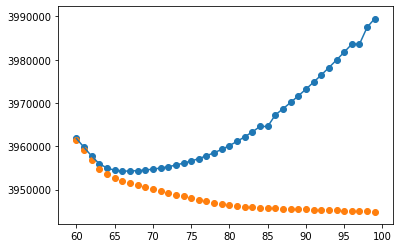

In [420]:
# models_all_ii = mix.ilp_select_models_bic(can_ii,verbose=False)

def bic(models):
    n = (sum(m._n_parameters() for m in models))
    para = n + (n*(n+1)/2)
    return (np.log(sum(m.weight_total for m in models)) * para) - (2 * sum(m.loglikelihood for m in models))

x = []
y = []
z = []
for i in range(60,100):
    for m in can_ii:
        for sm in m.submodels:
            sm._n_parameters = 2
    #print(len(can_ii))
    mods = mix.ilp_select_models_max(can_ii,i)
    x.append(i)
    y.append(bic(mods))
    z.append(- (2 * sum(m.loglikelihood for m in mods)))
#     print(list((m.name,m.n_components) for m in mods))
    
    #print((sum(m._n_parameters() for m in mods)))
    #print(i, sum(m.weight_total for m in mods) * (sum(m._n_parameters() for m in mods)))
#     print(i,- (2 * sum(m.loglikelihood for m in mods)))
#     print(i,bic(mods))
#     for m in mods:
#         print(m._n_iter)
#         print(m.loglikelihood)
#         print(np.sum(m.weights * np.log(m.responsibilities.sum(axis=1))))
plt.plot(x,y)
plt.scatter(x,y)
plt.scatter(x,z)
plt.show()

In [421]:
import mixture
for can in can_ii:
    for m in can.submodels:
        m._n_parameters = 1
    can.submodels[0]._n_parameters = 0
        #print(m._n_parameters)

models_all_ii = mix.ilp_select_models_bic_triangle(can_ii,verbose=True)
models_all_ = {m.name : m.n_components for m in models_all_ii}
models_solo_ii = mix.select_models_solo_bic(can_ii)
models_solo_ = {m.name : m.n_components for m in models_solo_ii}
list((m.name,models_all_[m.name], models_solo_[m.name]) for m in models_all_ii)
#sum(m._n_parameters() for m in models_all_ii)

Iter	Lower Bound	Upper Bound	Gap

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.964e+06  +2.954e+06  +5e+06  6e-01  2e-04  1e+00  5e+03    ---    ---    1  1  - |  -  - 
 1  +3.950e+06  +3.546e+06  +3e+06  3e-01  8e-05  4e+02  3e+03  0.4996  3e-01   1  2  2 |  0  0
 2  +3.940e+06  +3.517e+06  +3e+06  3e-01  9e-05  7e+02  3e+03  0.1744  9e-01   1  2  3 |  0  0
 3  +3.934e+06  +3.827e+06  +1e+06  8e-02  2e-05  4e+02  1e+03  0.7011  8e-02   1  2  2 |  0  0
 4  +3.934e+06  +3.831e+06  +1e+06  6e-02  2e-05  4e+02  1e+03  0.1141  7e-01   1  2  2 |  0  0
 5  +3.940e+06  +3.885e+06  +6e+05  4e-02  1e-05  2e+02  5e+02  0.9831  5e-01   1  2  2 |  0  0
 6  +3.942e+06  +3.894e+06  +5e+05  2e-02  8e-06  2e+02  5e+02  0.3336  6e-01   1  2  2 |  0  0
 7  +3.948e+06  +3.937e+06  +1e+05  5e-03  2e-06  4e+01  1e+02  0.9306  2e-01   1  2  2 |  0  0
 8  +3.948e+0

[('throw_in_0', 2, 6),
 ('throw_in_1', 2, 6),
 ('take_on_0', 1, 1),
 ('goal_0', 1, 1),
 ('owngoal_0', 1, 1),
 ('tackle_0', 1, 1),
 ('offside_0', 1, 2),
 ('goalkick_0', 1, 7),
 ('corner_0', 2, 2),
 ('corner_1', 2, 2),
 ('foul_0', 1, 1),
 ('cross_0', 1, 1),
 ('cross_1', 1, 1),
 ('freekick_0', 1, 1),
 ('yellow_card_0', 1, 1),
 ('pass_0', 2, 2),
 ('pass_1', 2, 2),
 ('pass_2', 2, 2),
 ('pass_3', 2, 2),
 ('pass_4', 2, 2),
 ('pass_5', 3, 6),
 ('pass_6', 2, 2),
 ('pass_7', 3, 6),
 ('pass_8', 2, 2),
 ('pass_9', 2, 2),
 ('out_0', 1, 1),
 ('out_1', 1, 1),
 ('clearance_0', 1, 8),
 ('clearance_1', 1, 3),
 ('shot_0', 1, 2),
 ('red_card_0', 1, 1),
 ('dribble_0', 1, 1),
 ('dribble_1', 1, 1),
 ('dribble_2', 1, 1),
 ('dribble_3', 1, 9),
 ('dribble_4', 2, 10),
 ('dribble_5', 3, 3),
 ('dribble_6', 1, 1),
 ('dribble_7', 2, 10),
 ('dribble_8', 1, 2),
 ('dribble_9', 3, 3),
 ('shot_penalty_0', 1, 2),
 ('bad_touch_0', 1, 1),
 ('keeper_catch_0', 1, 1),
 ('interception_0', 1, 1),
 ('interception_1', 1, 1),
 ('in

In [422]:
models_ii = models_all_ii
w_ii = probabilities(models_ii,a,cols_ii,w_i)
w_ii

throw_in_0_0  throw_in_0_1  throw_in_1_0  throw_in_1_1  take_on_0_0  \
0                0.0           0.0           0.0           0.0          0.0   
1                0.0           0.0           0.0           0.0          0.0   
2                0.0           0.0           0.0           0.0          0.0   
3                0.0           0.0           0.0           0.0          0.0   
4                0.0           0.0           0.0           0.0          0.0   
...              ...           ...           ...           ...          ...   
199995           0.0           0.0           0.0           0.0          0.0   
199996           0.0           0.0           0.0           0.0          0.0   
199997           0.0           0.0           0.0           0.0          0.0   
199998           0.0           0.0           0.0           0.0          0.0   
199999           0.0           0.0           0.0           0.0          0.0   

        goal_0_0  owngoal_0_0  tackle_0_0  offside_0_0  goalkick_0_0  ...  \
0            0.0          0.0         0.0          0.0           0.0  ...   
1            0.0          0.0         0.0          0.0           0.0  ...   
2            0.0          0.0         0.0          0.0           0.0  ...   
3            0.0          0.0         0.0          0.0           0.0  ...   
4            0.0          0.0         0.0          0.0           0.0  ...   
...          ...          ...         ...          ...           ...  ...   
199995       0.0          0.0         0.0          0.0           0.0  ...   
199996       0.0          0.0         0.0          0.0           0.0  ...   
199997       0.0          0.0         0.0          0.0           0.0  ...   
199998       0.0          0.0         0.0          0.0           0.0  ...   
199999       0.0          0.0         0.0          0.0           0.0  ...   

        receival_0_0  receival_1_0  receival_2_0  receival_3_0  receival_4_0  \
0           0.000000      0.000000      0.000000      0.000000      0.000000   
1           0.000594      0.629568      0.000277      0.000293      0.000003   
2           0.000000      0.000000      0.000000      0.000000      0.000000   
3           0.000000      0.000000      0.000000      0.000000      0.000000   
4           0.000097      0.762455      0.002180      0.000003      0.000002   
...              ...           ...           ...           ...           ...   
199995      0.000000      0.000000      0.000000      0.000000      0.000000   
199996      0.000000      0.000000      0.000000      0.000000      0.000000   
199997      0.448125      0.003026      0.000002      0.000722      0.007259   
199998      0.000000      0.000000      0.000000      0.000000      0.000000   
199999      0.000000      0.000000      0.000000      0.000000      0.000000   

        receival_5_0  receival_6_0  receival_7_0  receival_8_0  receival_9_0  
0           0.000000      0.000000      0.000000      0.000000      0.000000  
1           0.273006      0.000029      0.095875      0.000357      0.000000  
2           0.000000      0.000000      0.000000      0.000000      0.000000  
3           0.000000      0.000000      0.000000      0.000000      0.000000  
4           0.218745      0.000257      0.015906      0.000348      0.000007  
...              ...           ...           ...           ...           ...  
199995      0.000000      0.000000      0.000000      0.000000      0.000000  
199996      0.000000      0.000000      0.000000      0.000000      0.000000  
199997      0.253513      0.000000      0.287352      0.000000      0.000000  
199998      0.000000      0.000000      0.000000      0.000000      0.000000  
199999      0.000000      0.000000      0.000000      0.000000      0.000000  

[200000 rows x 79 columns]

throw_in 2
throw_in_0 2
throw_in_1 2


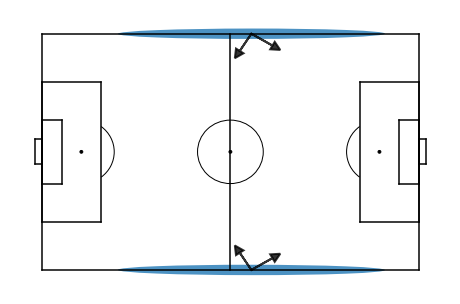

take_on 1
take_on_0 1


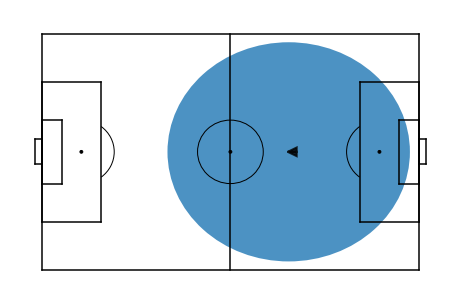

goal 1
goal_0 1


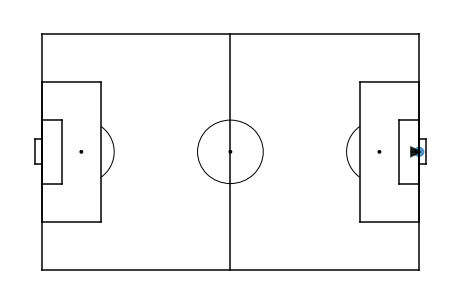

owngoal 1
owngoal_0 1


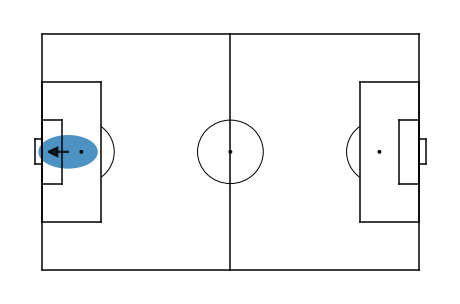

tackle 1
tackle_0 1


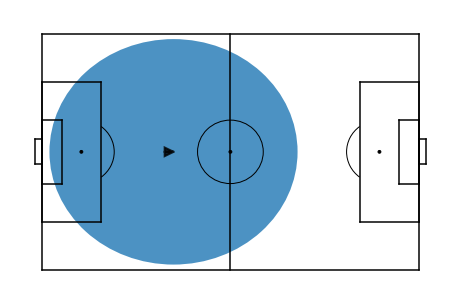

offside 1
offside_0 1


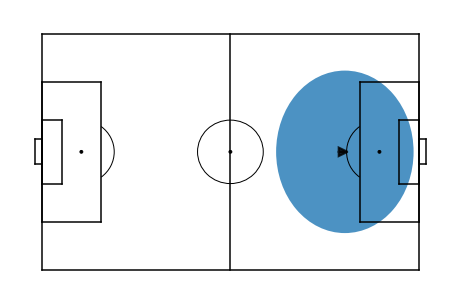

goalkick 1
goalkick_0 1


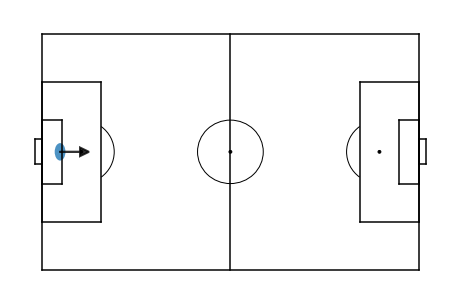

corner 2
corner_0 2
corner_1 2


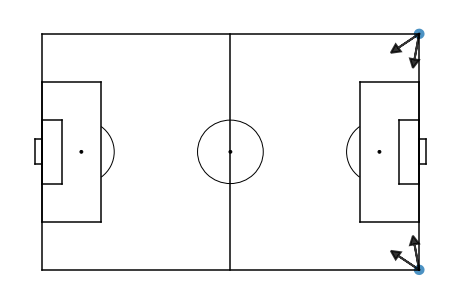

foul 1
foul_0 1


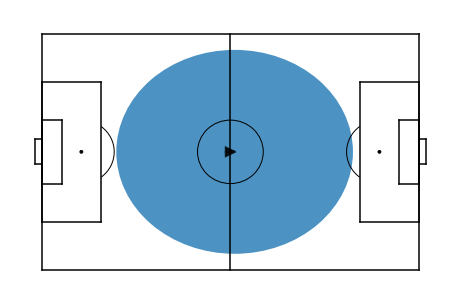

cross 2
cross_0 1
cross_1 1


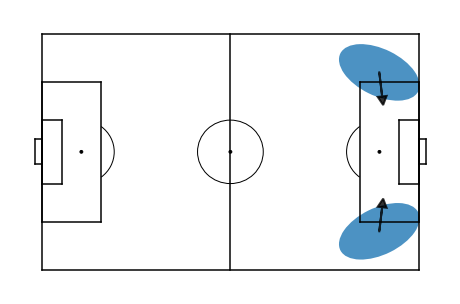

freekick 1
freekick_0 1


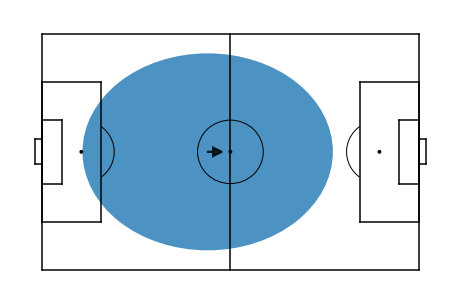

yellow_card 1
yellow_card_0 1


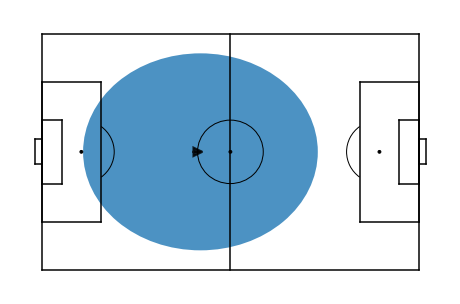

pass 10
pass_0 2
pass_1 2
pass_2 2
pass_3 2
pass_4 2
pass_5 3
pass_6 2
pass_7 3
pass_8 2
pass_9 2


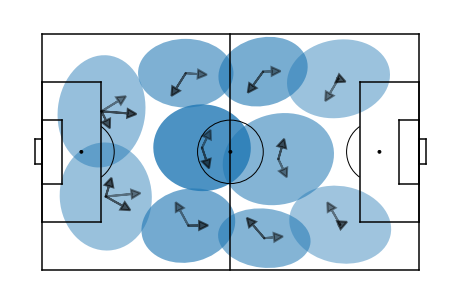

out 2
out_0 1
out_1 1


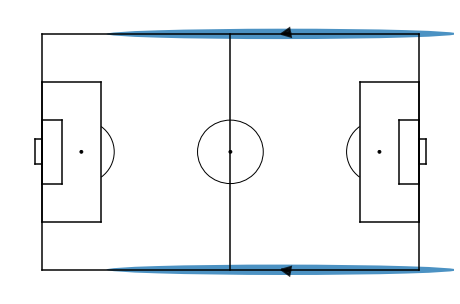

clearance 2
clearance_0 1
clearance_1 1


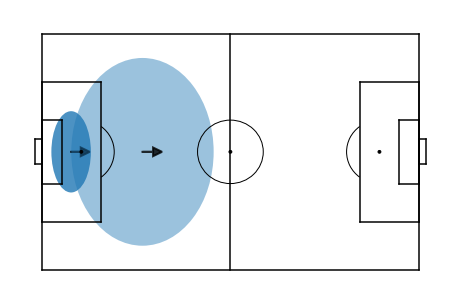

shot 1
shot_0 1


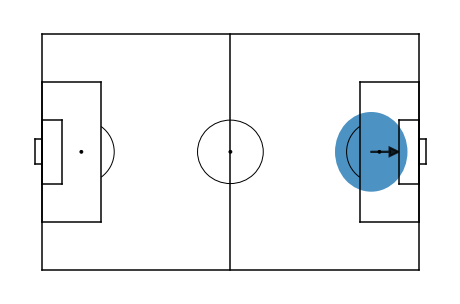

red_card 1
red_card_0 1


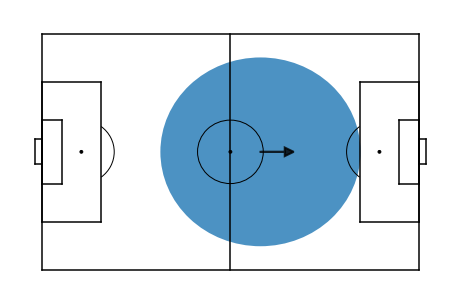

dribble 10
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 1
dribble_4 2
dribble_5 3
dribble_6 1
dribble_7 2
dribble_8 1
dribble_9 3


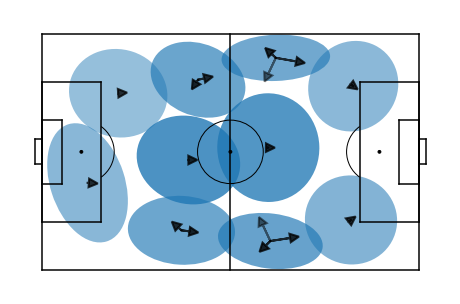

shot_penalty 1
shot_penalty_0 1


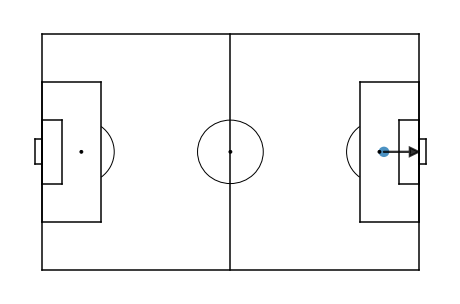

bad_touch 1
bad_touch_0 1


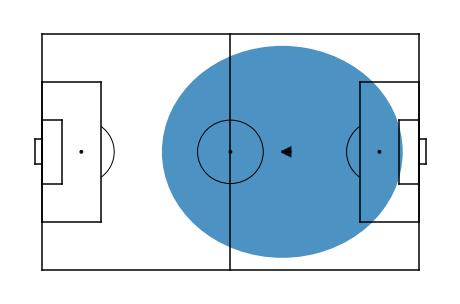

keeper_catch 1
keeper_catch_0 1


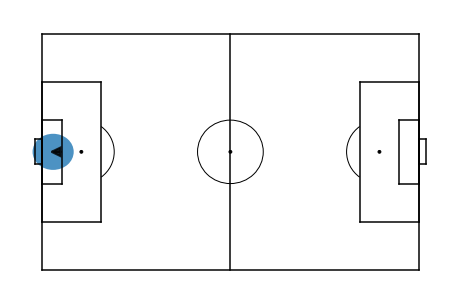

interception 3
interception_0 1
interception_1 1
interception_2 1


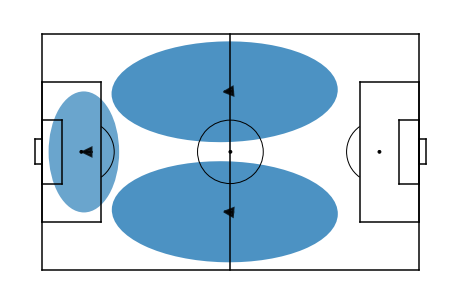

receival 10
receival_0 1
receival_1 1
receival_2 1
receival_3 1
receival_4 1
receival_5 1
receival_6 1
receival_7 1
receival_8 1
receival_9 1


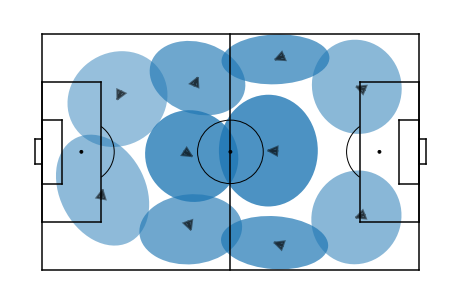

In [425]:
for model in models_i:
    ax = mps.field(show=False,figsize=8)
    print(model.name,model.n_components)
    norm_strengths = model.priors / np.max(model.priors) * 0.8
    for i,(strength,gauss) in enumerate(zip(norm_strengths,model.submodels)):
        vis.add_ellips(ax,gauss.mean,gauss.cov,alpha=strength)
        x,y = gauss.mean
        for model_ii in models_ii:
            if f"{model.name}_{i}" == model_ii.name:
                print(model_ii.name,model_ii.n_components)
                norm_strengths_ii = model_ii.priors / np.max(model_ii.priors) * 0.8
                for strength,vonmises in zip(norm_strengths,model_ii.submodels):
                    dx = np.cos(vonmises.loc)[0]
                    dy = np.sin(vonmises.loc)[0]
                    r = vonmises.R[0]
                    vis.add_arrow(ax,
                                  x,
                                  y,
                                  10*r*dx,
                                  10*r*dy,
                                  alpha=strength,threshold=0)
    plt.show()

In [ ]:
import math
for m_i in models_i:
    ax = mps.field(show=False,figsize=8)
    print(m_i.name)
    strengths_i = m_i.weights_ / np.max(m_i.weights_) * 0.8
    for i,(mean,covar,strength_i) in enumerate(zip(m_i.means_, m_i.covariances_,strengths_i)):
        vis.add_ellips(ax,mean,covar[:2,:2],alpha=strength_i)
        #vis.add_ellips(ax,mean,[[covar[0],0],[0,covar[1]]],alpha=strength_i)
        x,y = mean[:2]
        for m_ii in models_ii:
            if f"{m_i.name}_{i}" == m_ii.name:
                print(m_ii.name,m_ii.n_components)
                strengths_ii = m_ii.weights_ / np.max(m_ii.weights_)
                for j in range(m_ii.n_components):
                    we = w_ii[f"{m_ii.name}_{j}"].values
                    #x = np.average(m_ii.df["x"].values,weights=we)
                    #y = np.average(m_ii.df["y"].values,weights=we)
                    dx = np.average(m_ii.df["dx"].values,weights=we)
                    dy = np.average(m_ii.df["dy"].values,weights=we)
                    #norm = math.sqrt(dx*dx+dy*dy)
                    #dx,dy = dx/norm,dy/norm
                    strength_ii = strengths_ii[j]
                    d=1
                    vis.add_arrow(ax,x,y,d*dx,d*dy,
                                  alpha=strength_ii,
                                  #linewidth=2*strength_ii,
                                  #arrowsize=2.5*strength_ii,
                                  #linewidth=2,
                                  threshold=0)
    plt.title(f"Types of {m_i.name}")
    plt.show()

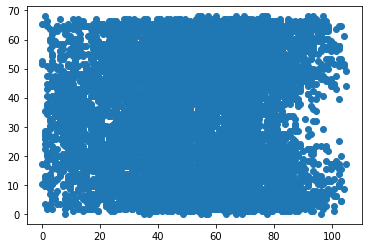

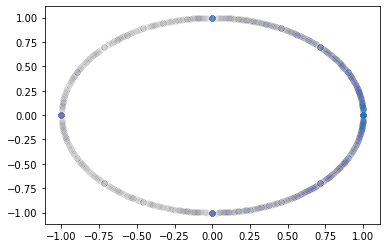

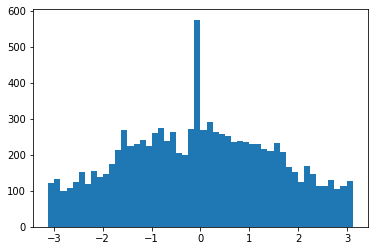

In [363]:

foo = a[#(a.mov_d_a0 > 5) 
        #& (a.mov_angle_a0 == 0)
        #& 
        (a.type_name == "pass")
       ][:10000]

plt.scatter(foo.x,foo.y)#a.mov_angle_a0[a.mov_d_a0 > 0],
         #weights=w_i[column].values
plt.show()
plt.scatter(foo.dx_a0,foo.dy_a0,alpha=0.005)#a.mov_angle_a0[a.mov_d_a0 > 0],
         #weights=w_i[column].values
plt.show()
# plt.scatter(foo.dx,foo.dy)#a.mov_angle_a0[a.mov_d_a0 > 0],
#          #weights=w_i[column].values
# plt.show()
foo.type_name.value_counts()
plt.hist(foo.mov_angle_a0,bins=50)
plt.show()

In [355]:
#probs = w_i[[col for col in w_i.columns if "pass" in col]]
probs.values.sum().sum(),sum(a.type_name == "pass"),w1["pass"].sum()

pro = 0
for column in w_i.columns:
    if "pass" in column:
        probs = w_i[column]
        #pos_prob_idx = probs > 1e-3
        pro += probs[a.mov_angle_a0.values == 0].sum()
        print(pro)
pro,sum(a[a.type_name == "pass"].mov_angle_a0 == 0)
#probs

151.614327348798
302.5188046425221
498.68300223016286
611.349632223714
777.8512782662358
962.0020613598306
1146.66327265152
1258.2576873714686
1375.3350211413992
1578.0


(1578.0, 1622)

pass_0 16508 4351.290968529888
['pass_0_0', 'pass_0_1']


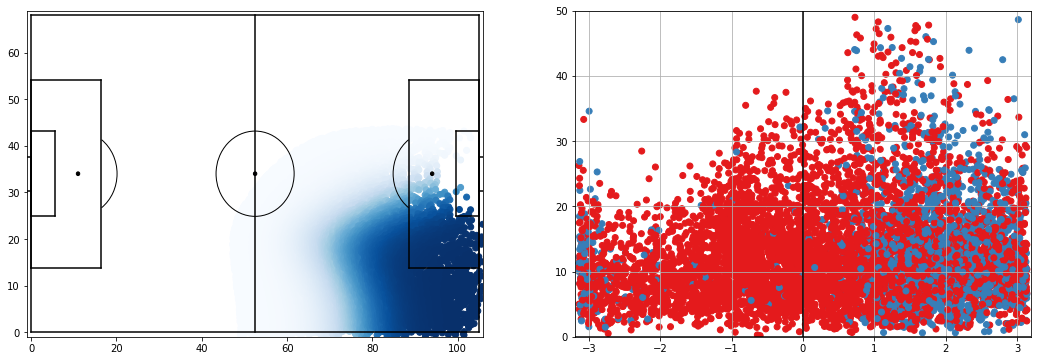

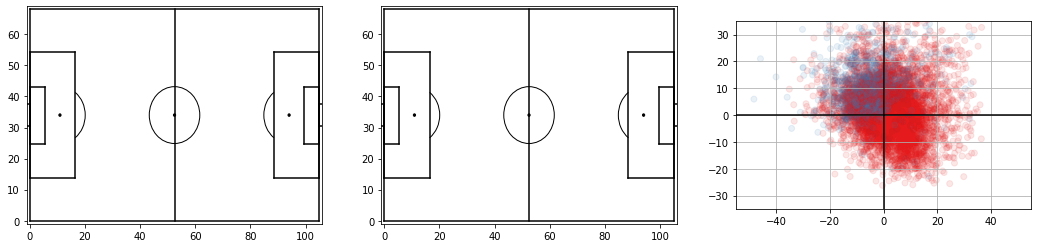

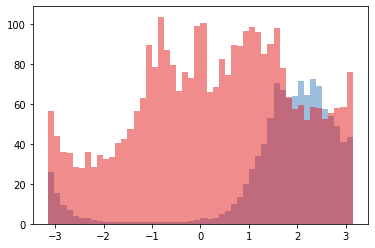

pass_1 23472 5925.226196583828
['pass_1_0', 'pass_1_1']


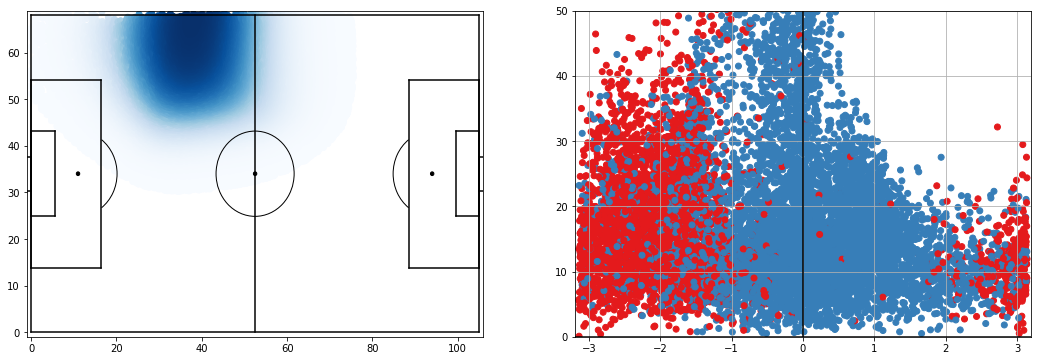

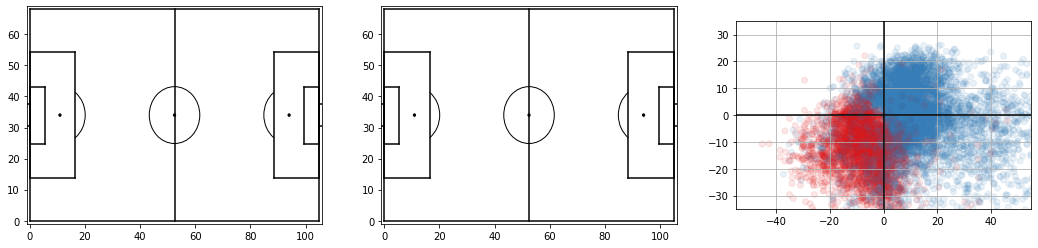

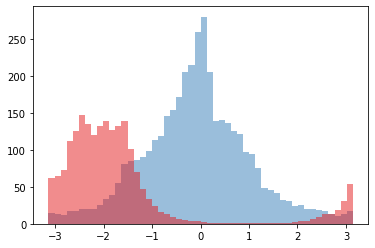

pass_2 25377 6381.091536135452
['pass_2_0', 'pass_2_1']


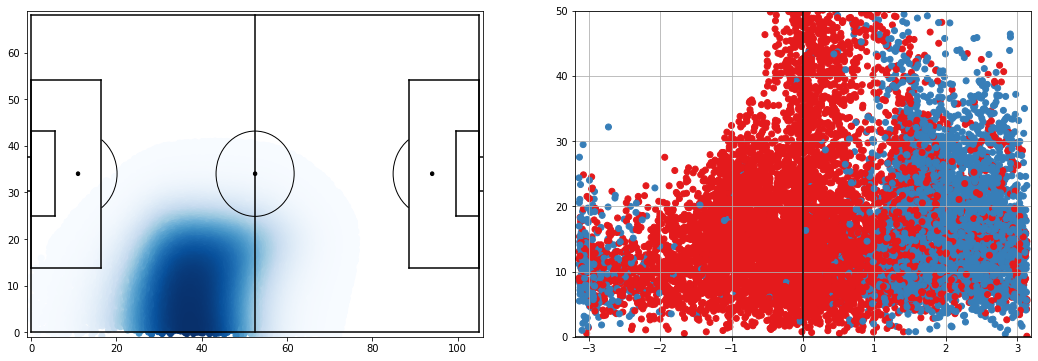

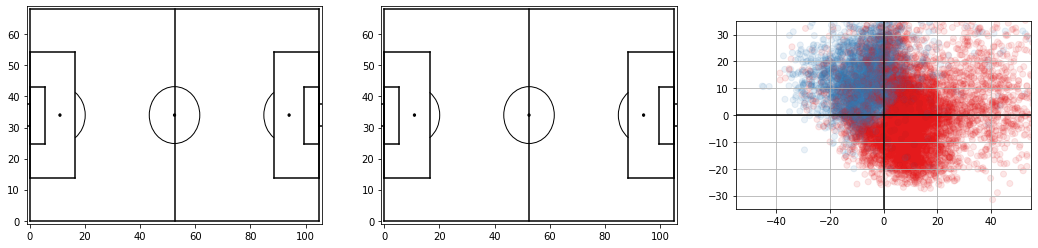

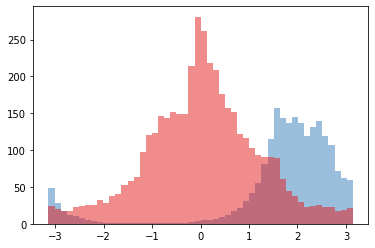

pass_3 23196 6177.869609113375
['pass_3_0', 'pass_3_1']


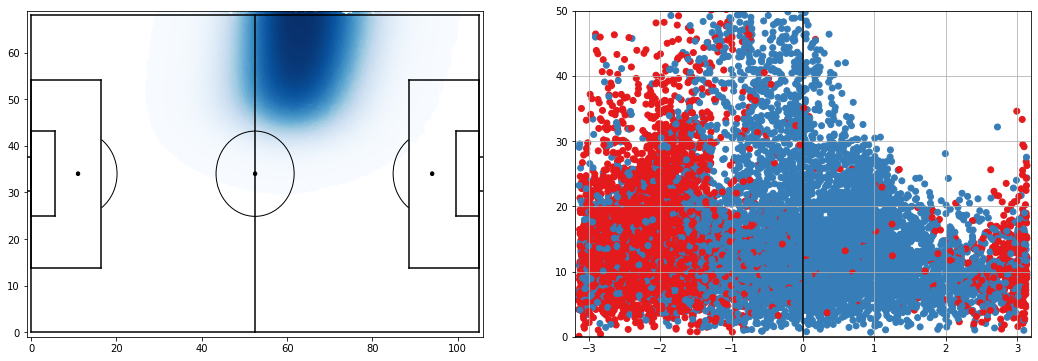

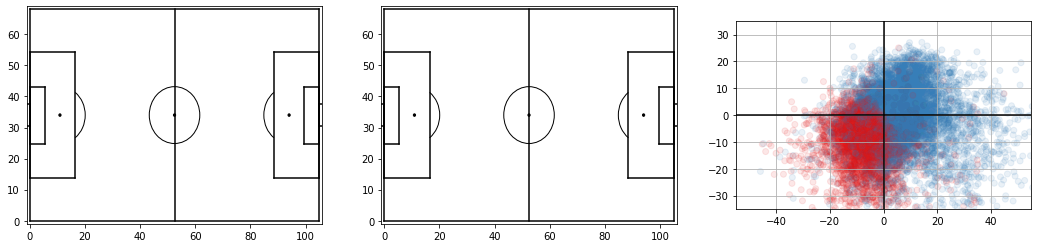

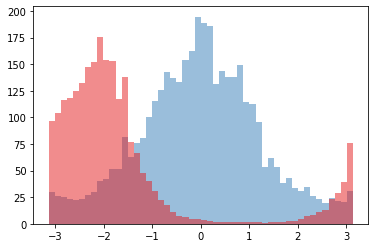

pass_4 41524 5746.497507513061
['pass_4_0', 'pass_4_1']


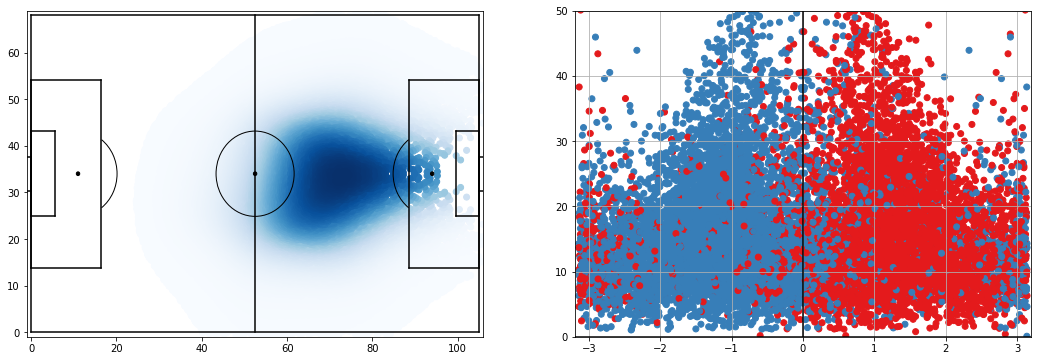

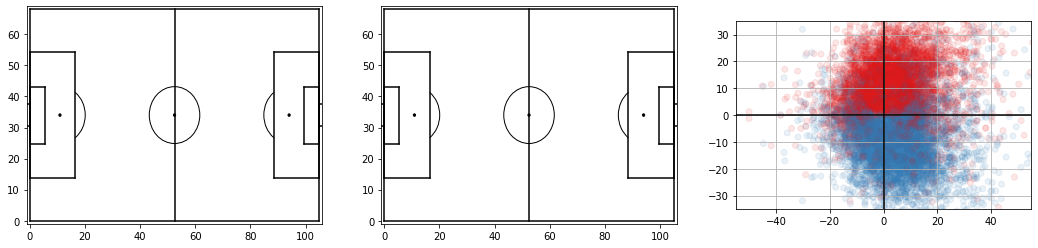

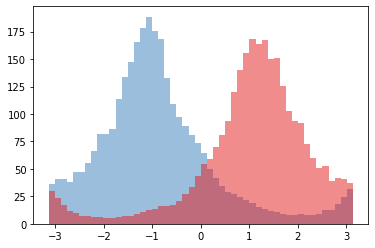

pass_5 21167 4626.20296829648
['pass_5_0', 'pass_5_1', 'pass_5_2']


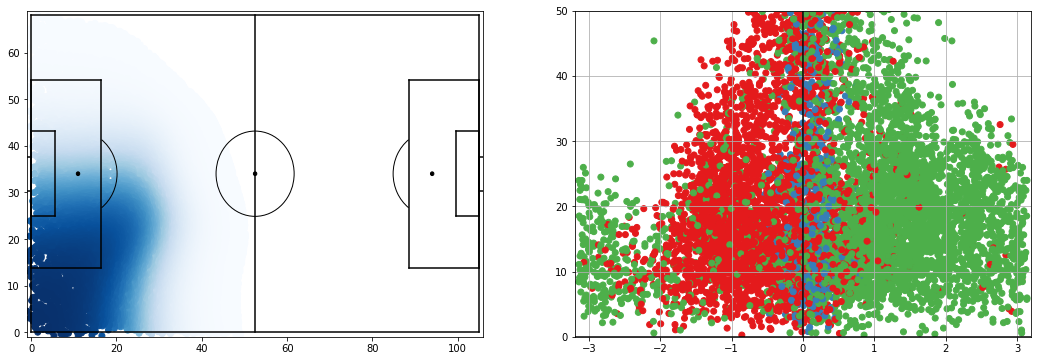

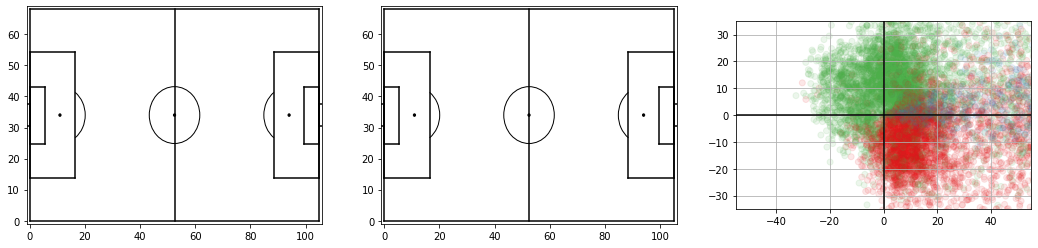

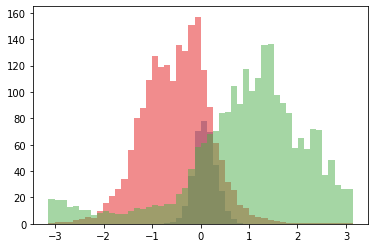

pass_6 42402 8351.585261072089
['pass_6_0', 'pass_6_1']


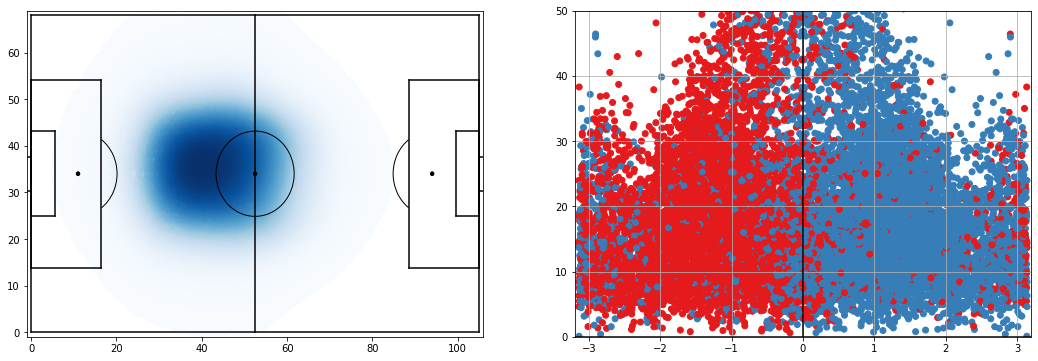

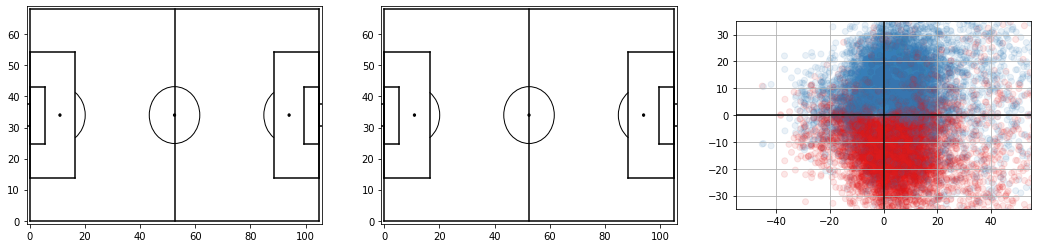

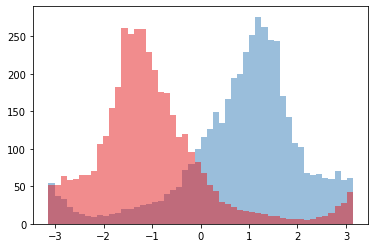

pass_7 19651 4743.685342600839
['pass_7_0', 'pass_7_1', 'pass_7_2']


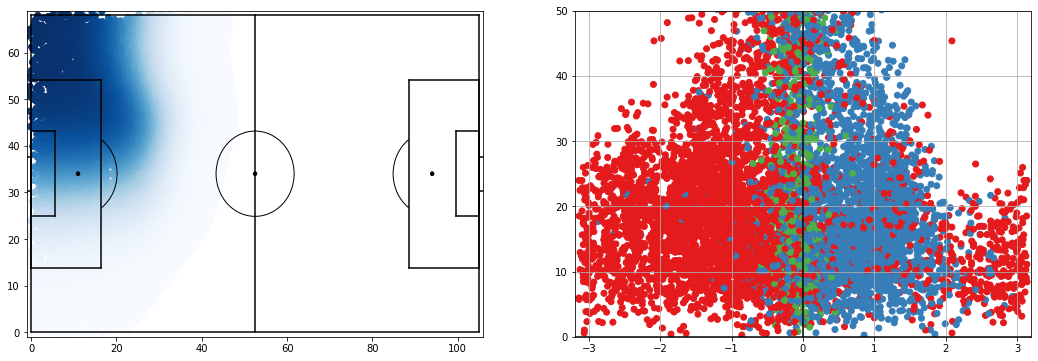

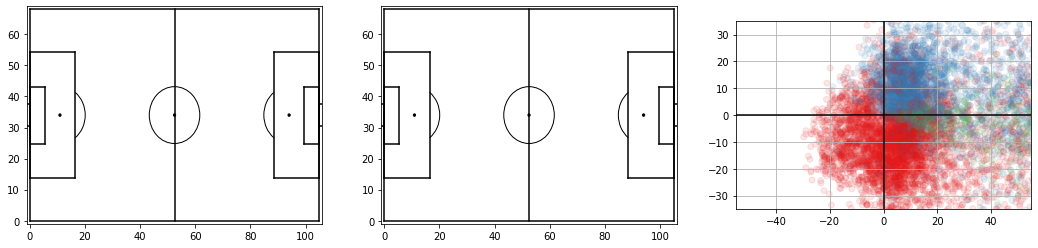

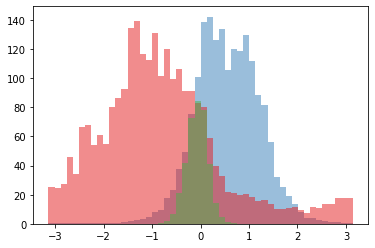

pass_8 20447 5619.267243659208
['pass_8_0', 'pass_8_1']


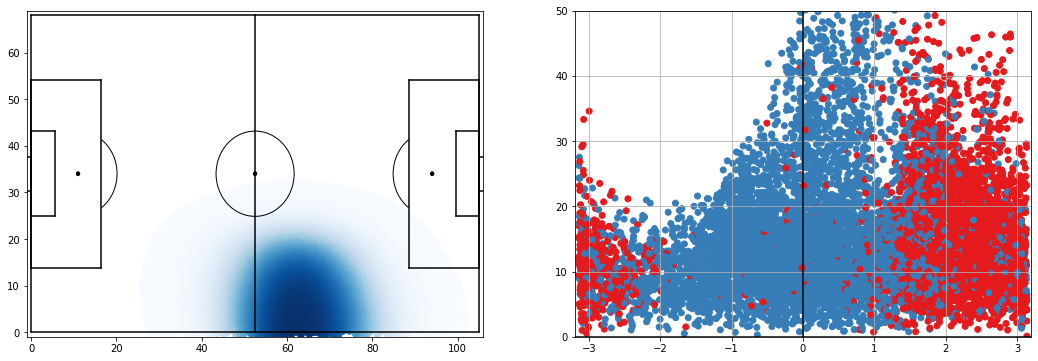

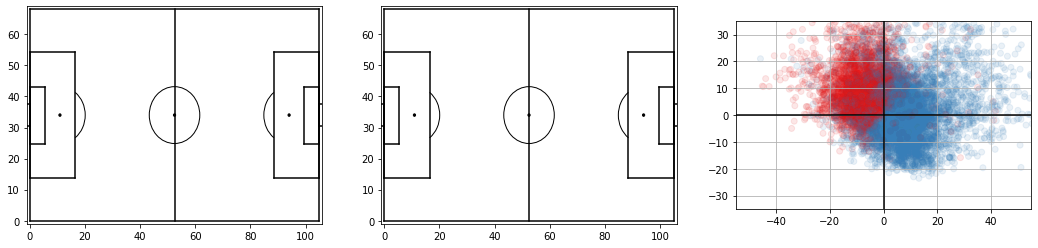

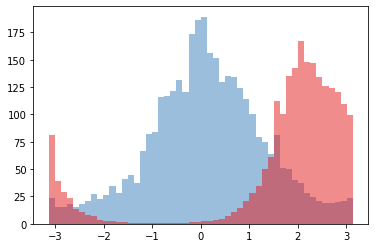

pass_9 17063 4575.283366494754
['pass_9_0', 'pass_9_1']


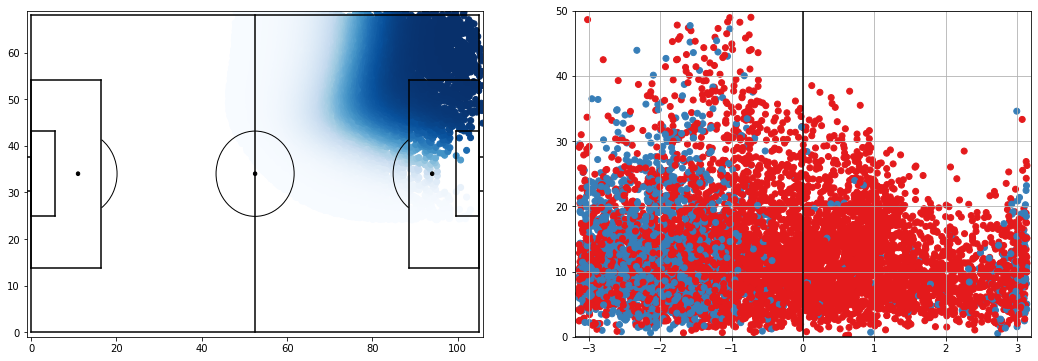

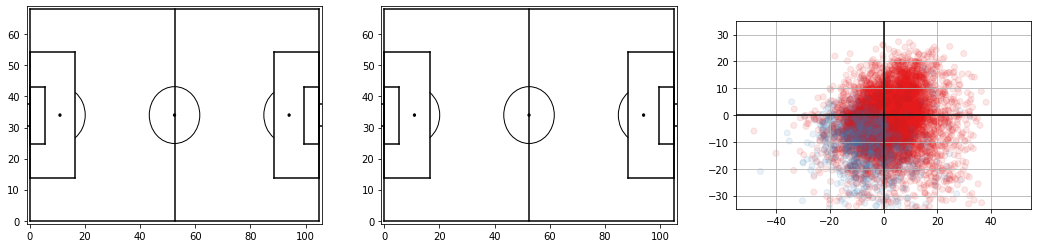

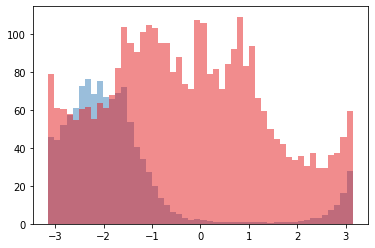

In [424]:
def sample(probs):
    n = len(probs)
    return np.random.choice(n,p=probs/sum(probs))


def scattercolors(actions,weights,samplefn="max"):
    pos_weights_idx = weights.values.sum(axis=1) > 1e-1
    a = actions[pos_weights_idx]
    weights = weights[pos_weights_idx]

    if samplefn == "max":
        labels = np.argmax(weights.values,axis=1)
    else:
        labels = np.apply_along_axis(sample,axis=1, arr=weights.values)

    pcolors = [colors[l % len(colors)] for l in labels]
    return a,pcolors

colors = ["#377eb8",
    "#e41a1c",
    "#4daf4a",
    "#984ea3",
    "#ff7f00",
    "#ffff33",
    "#a65628",
    "#f781bf",
    "#999999",
    ]


for column in w_i.columns:
    if "pass" in column:
        probs = w_i[column]
        pos_prob_idx = probs > 1e-3
        print(column,sum(pos_prob_idx),sum(probs))
        dfc = a.reset_index()[pos_prob_idx].copy()
        dfc["membership"] = probs[pos_prob_idx]
        dfc = dfc.sort_values("membership",ascending=True)

        axs = vis.axesxypolar()
        sc = axs[0].scatter(dfc.x,dfc.y,c=dfc.membership,cmap="Blues")
        #plt.colorbar(sc)
        #axs[1].scatter(dfc.x + dfc.dx,dfc.y + dfc.dy,c=dfc.membership,cmap="Blues")

        columns = list(name for name in w_ii.columns if column + "_" in name)
        print(columns)
        acol,c = scattercolors(a,w_ii[columns],samplefn="uni")
        axs[1].scatter(acol.mov_angle_a0,acol.mov_d_a0,c=c)
        #axs[1].scatter(dfc.mov_angle_a0,dfc.mov_d_a0,c=dfc.membership,cmap="Blues",alpha=0.1)
        plt.show()
        
        axs = vis.axes3()
        axs[2].scatter(acol.dx,acol.dy,c=c,alpha=0.1)
        plt.show()
        
#         plt.hist(a.mov_angle_a0,
#                  weights=w_i[column].values,
#                  bins=50)
#         plt.show()
#         print(w_i[column].values[a.mov_angle_a0.values ==0].sum())
        
#         plt.hist(a.mov_angle_a0.values[pos_prob_idx],
#                  bins=50)
#         plt.show()
#         plt.hist(a.mov_angle_a0,
#                  weights=w_i[column].values*a.mov_d_a0.values,
#                  bins=50)
#         plt.show()
        for i,co in enumerate(columns):
            weights = w_ii[co].values
            plt.hist(a.mov_angle_a0,bins=50,weights=weights,color=colors[i],alpha=0.5)
        plt.show()

In [ ]:
import numpy as np
for prefix in w_i.columns[:10]:
    prefix_columns = list(c for c in w_ii.columns if prefix + "_" in c)
    print(prefix,len(prefix_columns))
    vis.plot_actions(a,w_ii[prefix_columns],samplefn="uni")

pass_12_0 5492


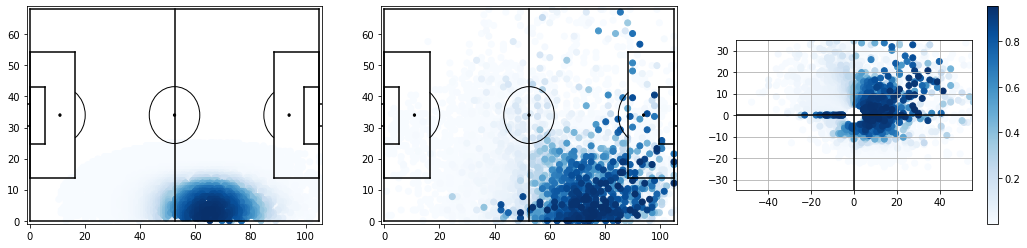

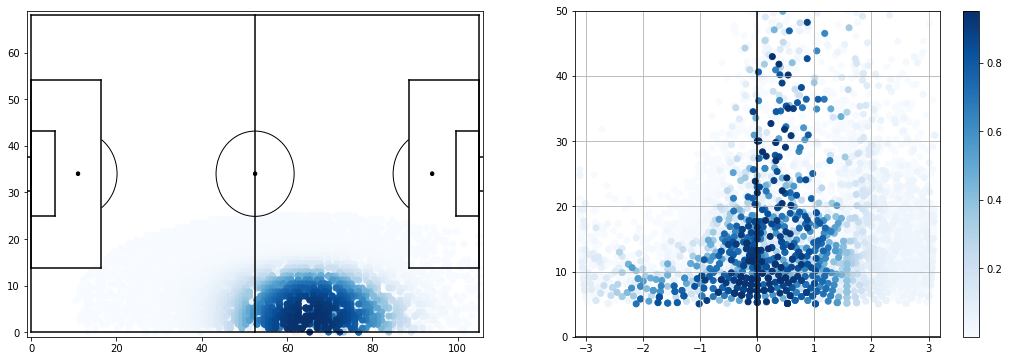

pass_12_1 5492


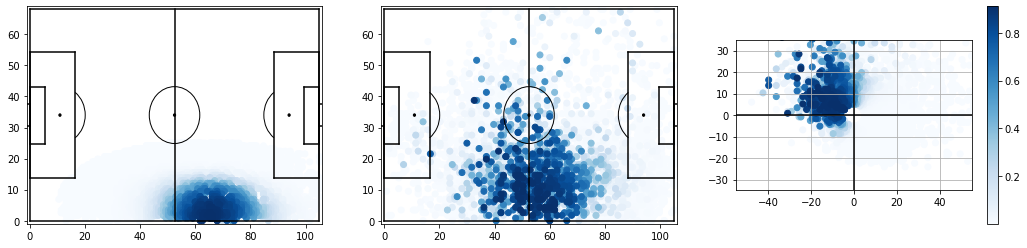

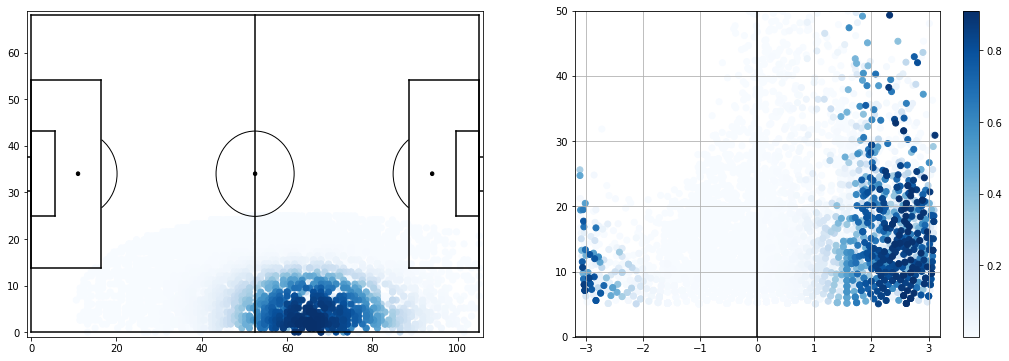

pass_13_0 2911


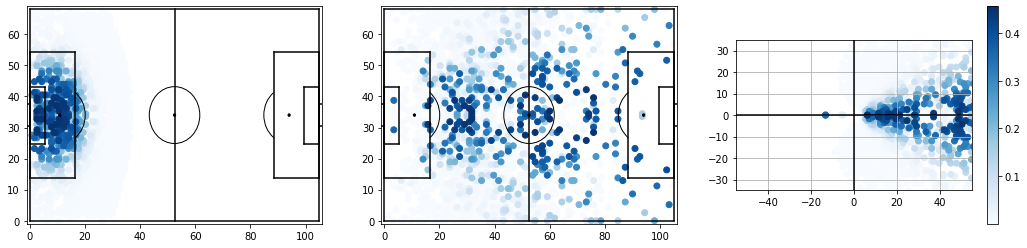

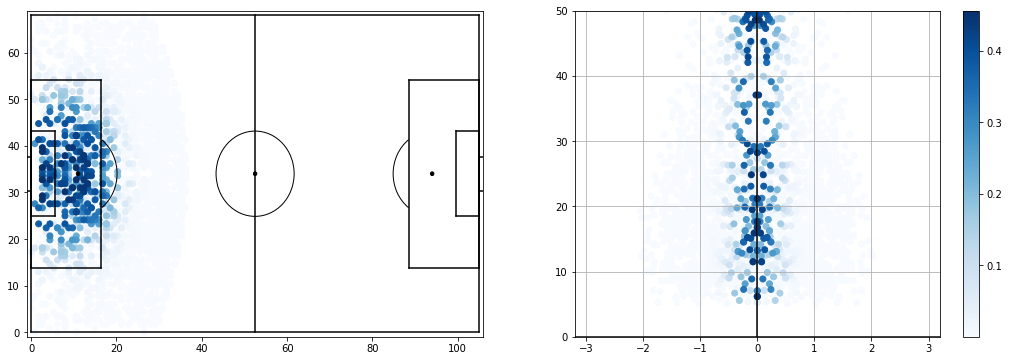

pass_13_1 3721


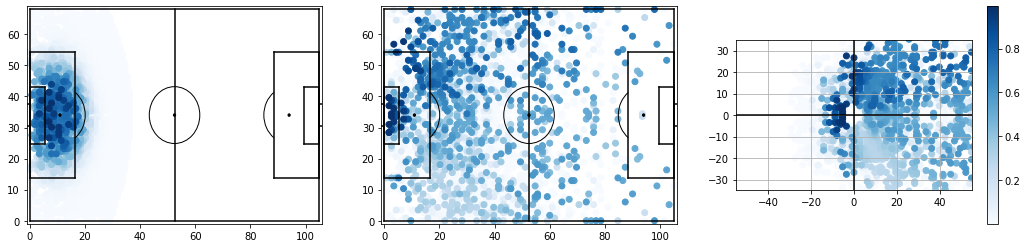

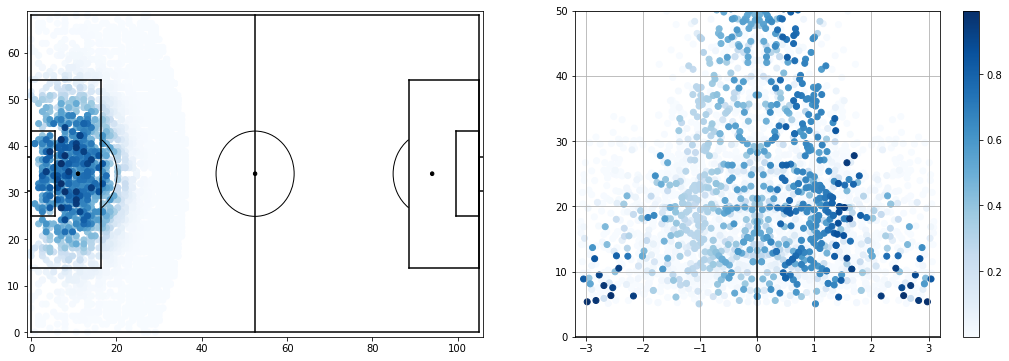

pass_13_2 2624


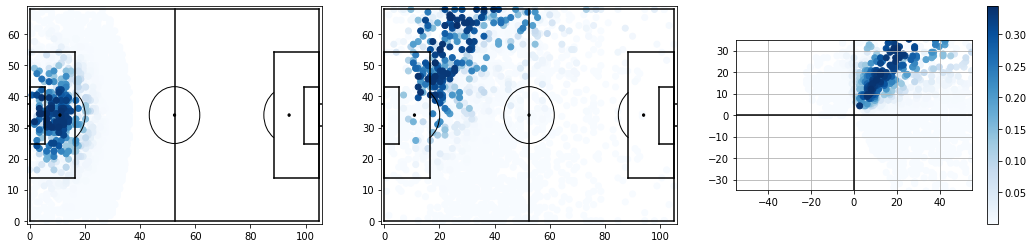

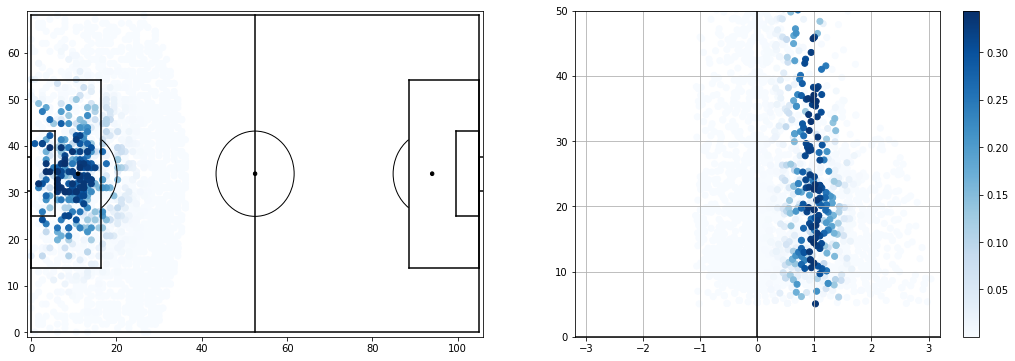

pass_13_3 3392


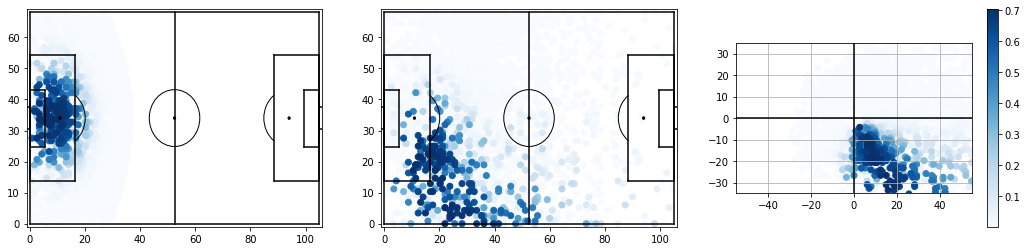

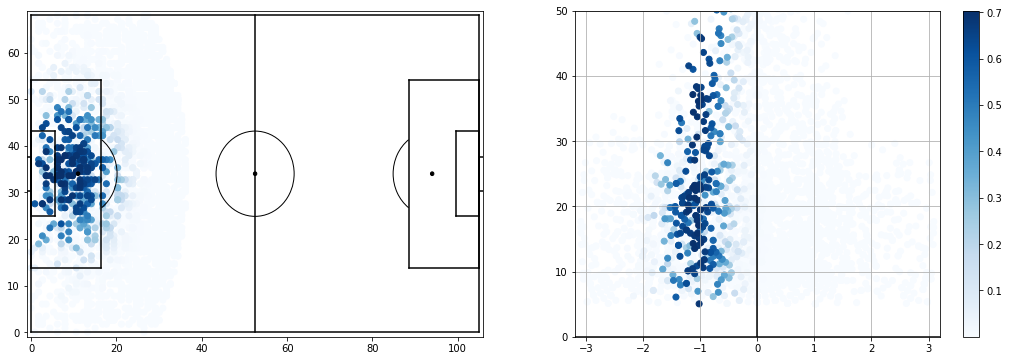

pass_14_0 11381


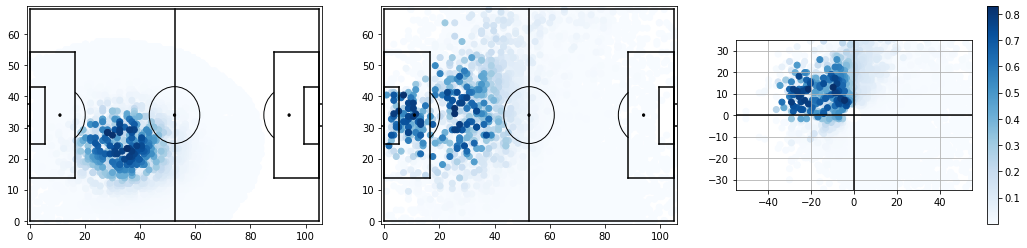

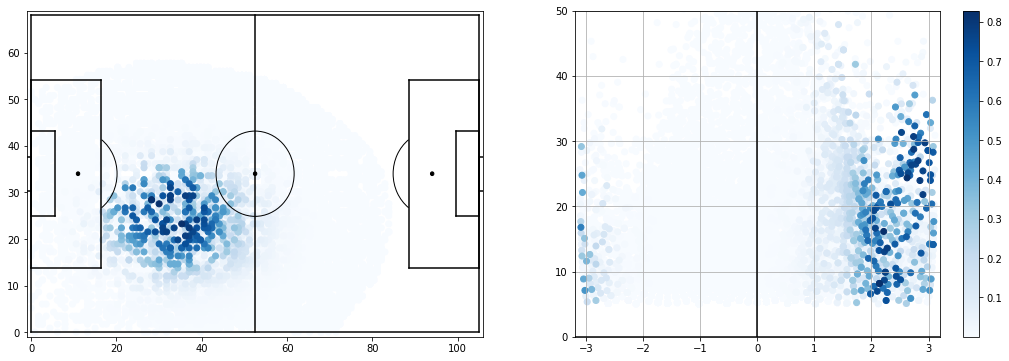

pass_14_1 6664


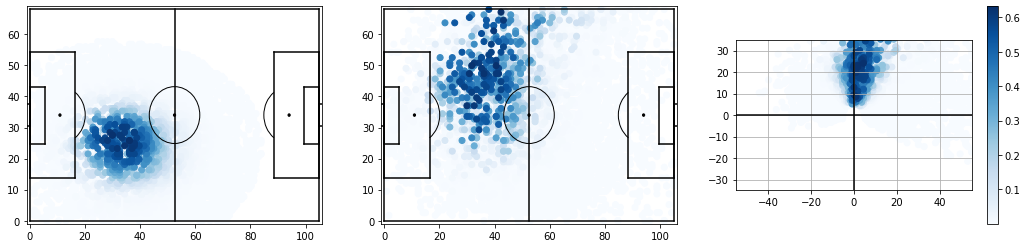

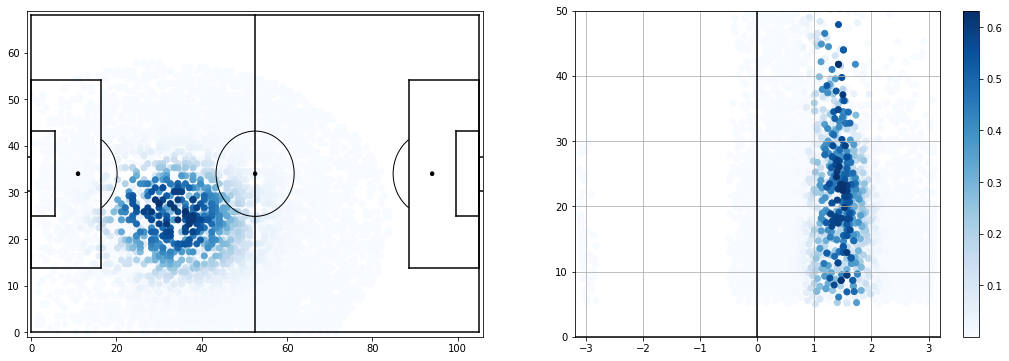

pass_14_2 7044


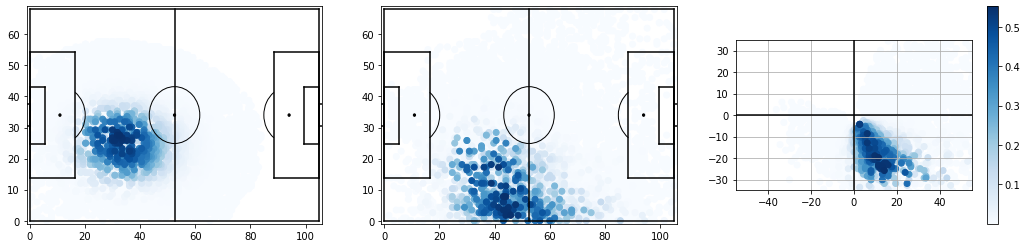

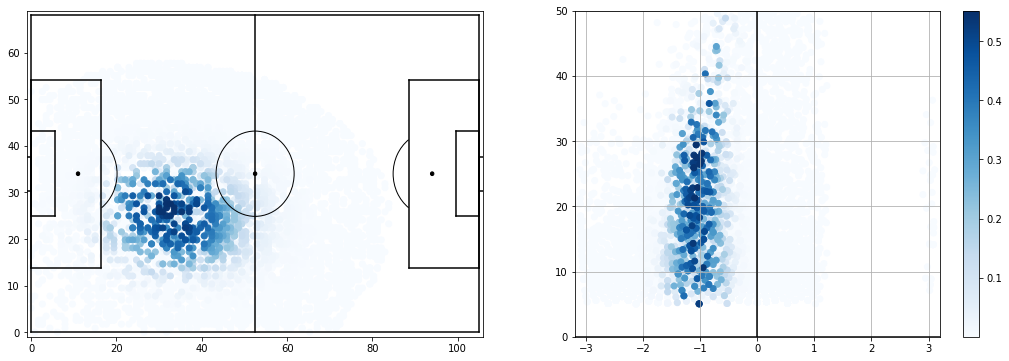

pass_14_3 11381


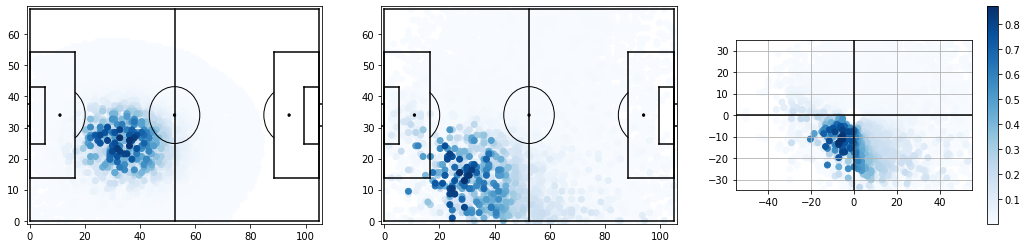

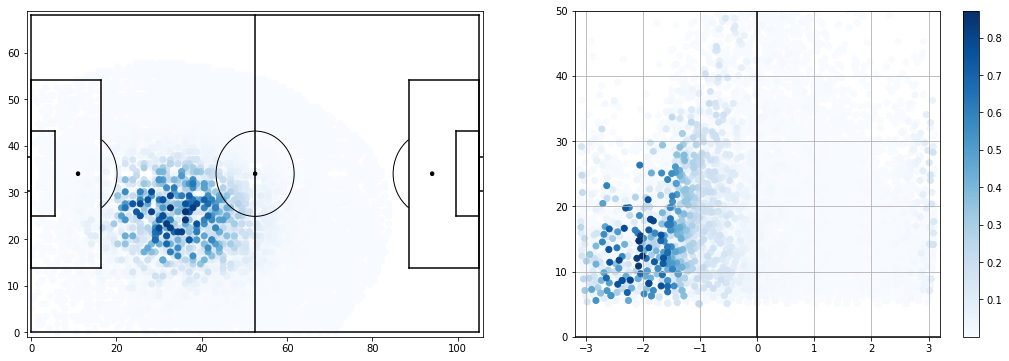

In [58]:
for column in w_ii.columns[50:60]:
    probs = w_ii[column]
    pos_prob_idx = probs > 1e-10
    print(column,sum(pos_prob_idx))
    dfc = a.reset_index()[pos_prob_idx].copy()
    dfc["membership"] = probs[pos_prob_idx]
    dfc = dfc.sort_values("membership",ascending=True)

    axs = vis.axes3()
    sc = axs[0].scatter(dfc.x,dfc.y,c=dfc.membership,cmap="Blues")
    plt.colorbar(sc)
    axs[1].scatter(dfc.x + dfc.dx,dfc.y + dfc.dy,c=dfc.membership,cmap="Blues")
    axs[2].scatter(dfc.dx,dfc.dy,c=dfc.membership,cmap="Blues")
    plt.show()

    axs = vis.axesxypolar()
    sc = axs[0].scatter(dfc.x,dfc.y,c=dfc.membership,cmap="Blues")
    plt.colorbar(sc)
    #axs[1].scatter(dfc.x + dfc.dx,dfc.y + dfc.dy,c=dfc.membership,cmap="Blues")
    axs[1].scatter(dfc.mov_angle_a0,dfc.mov_d_a0,c=dfc.membership,cmap="Blues")
    #axs[1].hist(dfc.mov_angle_a0)
    
    plt.show()